# Design for dual channel waveform Encoder+Hierarchical clustering

# Training need to be refined. features imperfect!!!

# Add curve fitting features

In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.optimize import curve_fit

import fastcluster as fc

CPU times: user 1.17 s, sys: 415 ms, total: 1.59 s
Wall time: 2.46 s


In [2]:
%%time
test = uproot.open("sig6.root")["tree"]
Phonon = test.array("HeightHeat")
Photon = test.array("HeightLight")
eventid = test.array("EventNumber")
print(Photon[1].shape,Phonon.shape,eventid)


(2000,) (96358, 2000) [    1     2     3 ... 96356 96357 96358]
CPU times: user 11.2 s, sys: 2.96 s, total: 14.2 s
Wall time: 18.9 s


# Obtain plot parameters

In [3]:
%%time
length = len(Photon)

ped_heat = np.mean(Phonon[:,50:350], axis=1)
ped_light = np.mean(Photon[:,50:350], axis=1)

for i,j in enumerate(Phonon):
        Phonon[i] = Phonon[i] - ped_heat[i]
        Photon[i] = Photon[i] - ped_light[i]

start_heat_min = np.empty(length)
start_heat_max = np.argmax(Phonon[:,390:570], axis=1)

start_light_min = np.empty(length)
start_light_max = np.argmax(Photon[:,390:570], axis=1)

for i,j in enumerate(Phonon):
    for k,m in enumerate(j[390:570]):
        if m > 0.1*j[int(start_heat_max[i]+390)]:
            start_heat_min[i] = int(k+390)
            break
            
for i,j in enumerate(Photon):
    for k,m in enumerate(j[390:570]):
        if m > 0.05*j[int(start_light_max[i]+390)]:
            start_light_min[i] = int(k+390)
            break

start_heat_max+=390
start_light_max+=390

rise_heat = np.subtract(start_heat_max, start_heat_min)
rise_light = np.subtract(start_light_max, start_light_min)

energy_light = np.amax(Photon[:,380:420], axis=1)

energy_heat = np.empty(length)
energy_heat1 = np.empty(length)
energy_heat2 = np.empty(length)
# energy_heat2 = np.amax(Phonon[:,360:420], axis=1)

for i in range(length):
    energy_heat[i] = Phonon[i,int(start_heat_min[i]+400)]
    energy_heat1[i] = Phonon[i,int(start_heat_min[i]+370)]
    energy_heat2[i] = Phonon[i,int(start_heat_min[i]+350)]

ratio = energy_light/energy_heat
ratio1 = energy_light/energy_heat1
ratio2 = energy_light/energy_heat2

# # Normalizaion
# norm_heat = np.amax(Phonon,axis=1)
# norm_light = np.amax(Photon,axis=1)

# for i,j in enumerate(Phonon):
#     if norm_heat[i] > norm_light[i]:
#         Phonon[i] = Phonon[i]/norm_heat[i]
#         Photon[i] = Photon[i]/norm_heat[i]
#     if norm_light[i] > norm_heat[i]:
#         Phonon[i] = Phonon[i]/norm_light[i]
#         Photon[i] = Photon[i]/norm_light[i]

CPU times: user 23.3 s, sys: 94 ms, total: 23.4 s
Wall time: 23.5 s


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide


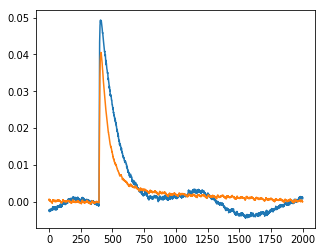

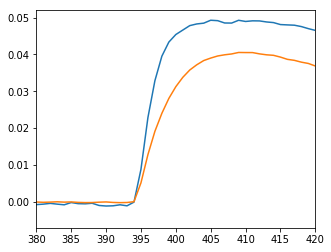

In [12]:
r = np.random.randint(len(Phonon))
plt.figure()
plt.plot(Photon[r])
plt.plot(Phonon[r])
# plt.xlim(380,420)
plt.show()

plt.figure()
plt.plot(Photon[r])
plt.plot(Phonon[r])
plt.xlim(380,420)
plt.show()

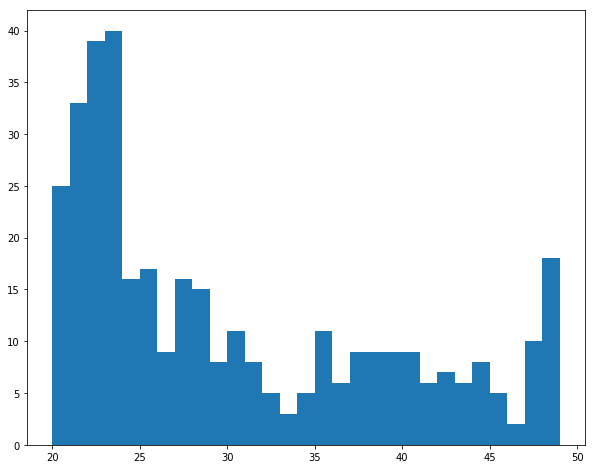

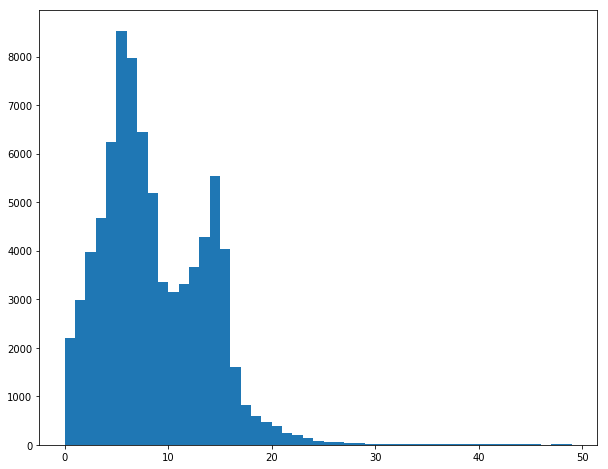

In [70]:
plt.figure(figsize=(10,8))
plt.hist(rise_heat,bins=np.arange(20,50,1))
plt.show()

plt.figure(figsize=(10,8))
plt.hist(rise_light,bins=np.arange(0,50,1))
plt.show()

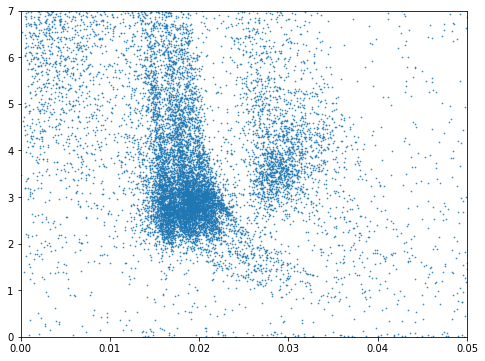

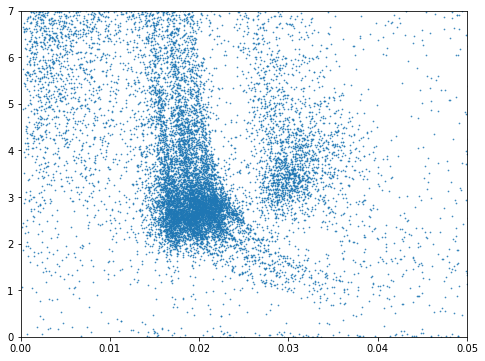

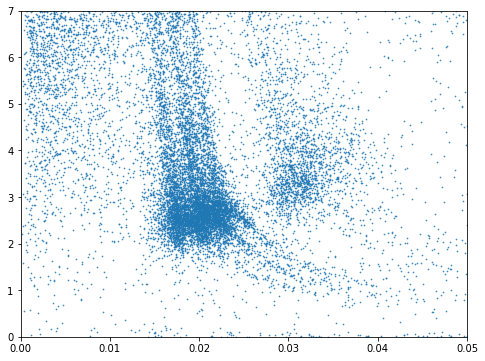

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(energy_heat,ratio, alpha=0.8, marker=".", s=2)
plt.xlim(0,0.05)
plt.ylim(0,7)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(energy_heat1,ratio1, alpha=0.8, marker=".", s=2)
plt.xlim(0,0.05)
plt.ylim(0,7)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(energy_heat2,ratio2, alpha=0.8, marker=".", s=2)
plt.xlim(0,0.05)
plt.ylim(0,7)
plt.show()

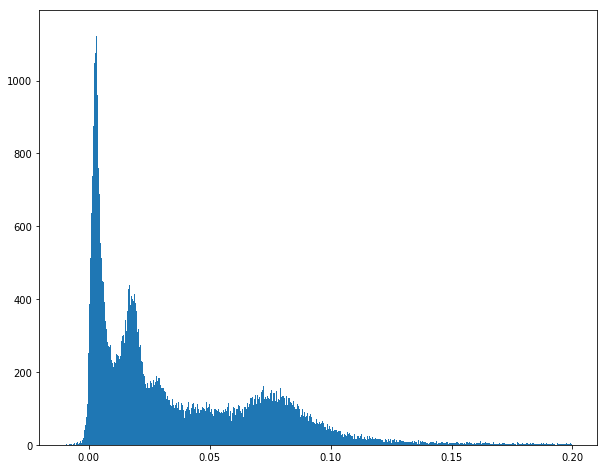

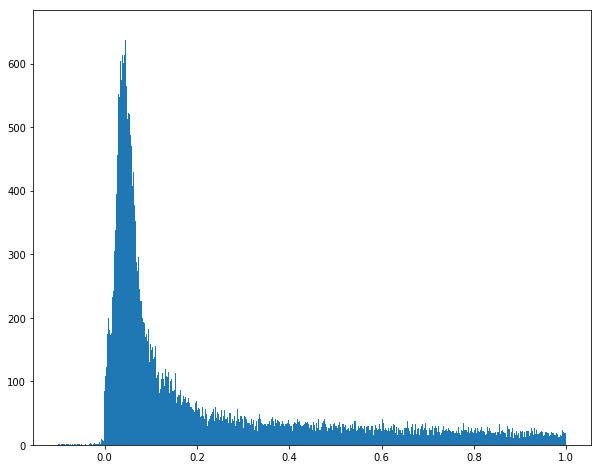

In [57]:
plt.figure(figsize=(10,8))
plt.hist(energy_heat,bins=np.arange(-0.01,0.2,0.0002))
plt.show()

plt.figure(figsize=(10,8))
plt.hist(energy_light,bins=np.arange(-0.1,1,0.001))
plt.show()

# Curve fitting via least-squared method
add start channel, fit first few portion not whole waveform

# Decay time then rise time

In [ ]:
%%time
def funcd(t, A0, A1, d0, d1):
    t*0.00001
    A0 > A1
    d0 > d1
    
    d0 > A0
    d1 > A1
    
    y1 = A0*(np.exp(-t/d0))
    y2 = A1*(np.exp(-t/d1))
    return y1+y2

# def func(t, r0, d0):
#     y1 = A0*(np.exp(-t/r0)+np.exp(-t/d0))
# #     y2 = A1*(np.exp(-t/r1)+np.exp(-t/d1))
# #     y3 = A2*((A0/(A0+A1))*np.exp(-t/r0) + (A1/(A0+A1))*np.exp(-t/r1))
#     return y1

parameters = np.empty((length,4))

x = np.arange(0, 300, 1)

for i,j in enumerate(Phonon):
    start = start_heat_max[i]
    popt, pcov = curve_fit(funcd, x, m[0,start:(start+300)], 
                           maxfev=5000, bounds=(0,[np.Inf,np.Inf,np.Inf,np.Inf]), 
                           method="trf")
    parameters[i] = popt

#     plt.figure(figsize=(6,5))
#     plt.plot(x,j[start:(start+800)], label="data")
#     plt.plot(x,funcd(x,popt[0],popt[1],popt[2],popt[3]), label="fit")
#     plt.legend()
#     plt.show()
#         print(k,popt)
#     print(pcov.shape)
#     if i==100:
#         break

print(parameters[:,0].shape)

plt.figure()
plt.hist(parameters[:,0])
plt.show()

plt.figure()
plt.hist(parameters[:,1])
plt.show()

plt.figure()
plt.hist(parameters[:,2])
plt.show()

plt.figure()
plt.hist(parameters[:,3])
plt.show()

In [7]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


class Autoencoder_2c(nn.Module):
    def __init__(self):
        super(Autoencoder_2c, self).__init__()        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(2, 32, kernel_size=8, stride=4, padding=0)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(32, 32, kernel_size=8, stride=4, padding=0)
        self.pl21 = nn.MaxPool1d(2, stride=4)
        self.cv22 = nn.Conv1d(32, 32, kernel_size=8, stride=4, padding=0)
        self.pl22 = nn.MaxPool1d(2, stride=4)
                
        self.ct1 = nn.ConvTranspose1d(32, 32, kernel_size=8, stride=4, padding=2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=6, stride=4, padding=4)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 2, kernel_size=8, stride=4,padding=2)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), z
print("Autoencoder")

GEN = Autoencoder_2c()
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder_2c(
  (cv1): Conv1d(2, 32, kernel_size=(8,), stride=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(32, 32, kernel_size=(8,), stride=(4,))
  (pl21): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(32, 32, kernel_size=(8,), stride=(4,))
  (pl22): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(32, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(32, 32, kernel_size=(6,), stride=(4,), padding=(4,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 2, kernel_size=(8,), stride=(4,), padding=(2,))
)
torch.Size([32, 2, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32, 6])
torch.Size([32])
torch.Size([32, 2

In [8]:
GEN.load_state_dict(torch.load("dual_plus.pkl"))


In [9]:
TEST = GEN(Variable(torch.randn(1000,2,2000)))
# DATA = TEST[0].reshape(BATCH_SIZE,1,-1)
print(TEST[0].size())
print(TEST[1].size())
# print(DATA.size())
# print(TEST[2].size())

torch.Size([1000, 2, 2000])
torch.Size([1000, 32, 8])


In [10]:
# Normalize and make dataset for loader
norm_heat = np.amax(Phonon,axis=1)
norm_light = np.amax(Photon,axis=1)

dataset = np.zeros((len(Phonon),2,2000))
for i in range(len(Phonon)):
    if norm_heat[i] > norm_light[i]:
        dataset[i][0] = Phonon[i]/norm_heat[i]
        dataset[i][1] = Photon[i]/norm_heat[i] 
    if norm_light[i] > norm_heat[i]:
        dataset[i][0] = Phonon[i]/norm_light[i]
        dataset[i][1] = Photon[i]/norm_light[i]

# del Phonon,Photon

In [11]:
BATCH = 3000
train_loader = DataLoader(dataset=dataset,
                         batch_size=BATCH,
                         shuffle=False,
                         num_workers=2)

n_batches = int(len(dataset)/BATCH)
del dataset

In [14]:
%%time
N_EPOCHS = 20
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        for batch_number, waveform in enumerate(train_loader):
            
            target = waveform.float()
            outputs = GEN(waveform.float())

            loss = criterion(outputs[0], target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            if (batch_number +1)%5 == 0:
                print("Epoch[%d/%d], Step[%d/%d], loss=%.6f"
                      %(epoch+1,
                        N_EPOCHS,
                        batch_number+1,
                        n_batches,
                        loss.data[0] ))
except KeyboardInterrupt:
    print('Training ended early.')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch[1/20], Step[5/18], loss=0.019795
Epoch[1/20], Step[10/18], loss=0.017901
Epoch[1/20], Step[15/18], loss=0.015625
Epoch[2/20], Step[5/18], loss=0.013277
Epoch[2/20], Step[10/18], loss=0.014976
Epoch[2/20], Step[15/18], loss=0.014017
Epoch[3/20], Step[5/18], loss=0.012973
Epoch[3/20], Step[10/18], loss=0.014433
Epoch[3/20], Step[15/18], loss=0.013712
Epoch[4/20], Step[5/18], loss=0.012720
Epoch[4/20], Step[10/18], loss=0.014247
Epoch[4/20], Step[15/18], loss=0.013570
Epoch[5/20], Step[5/18], loss=0.012634
Epoch[5/20], Step[10/18], loss=0.014183
Epoch[5/20], Step[15/18], loss=0.013516
Epoch[6/20], Step[5/18], loss=0.012581
Epoch[6/20], Step[10/18], loss=0.014134
Epoch[6/20], Step[15/18], loss=0.013473
Epoch[7/20], Step[5/18], loss=0.012565
Epoch[7/20], Step[10/18], loss=0.014094
Epoch[7/20], Step[15/18], loss=0.013463
Epoch[8/20], Step[5/18], loss=0.012498
Epoch[8/20], Step[10/18], loss=0.014090
Epoch[8/20], Step[15/18], loss=0.013415
Epoch[9/20], Step[5/18], loss=0.012515
Epoch[9/2

In [15]:
torch.save(GEN.state_dict(),"dual_plus.pkl")

# Cross Validation with Hierarchical clustering - figure out a good way to determine the number of clusters

# Cross Validation

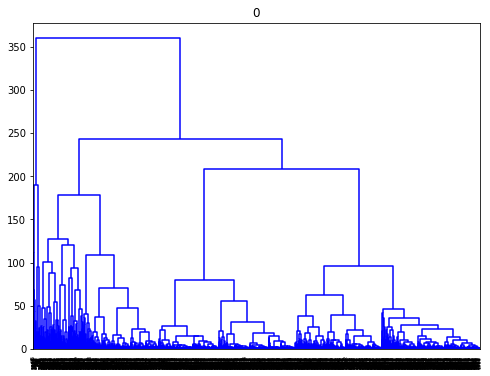

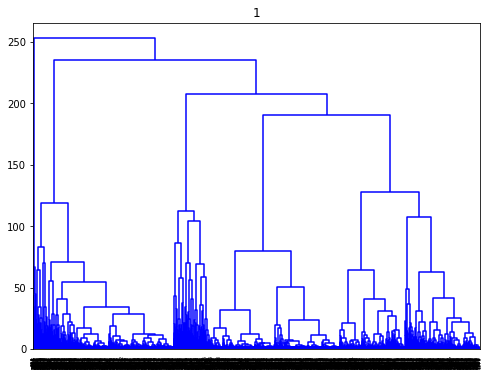

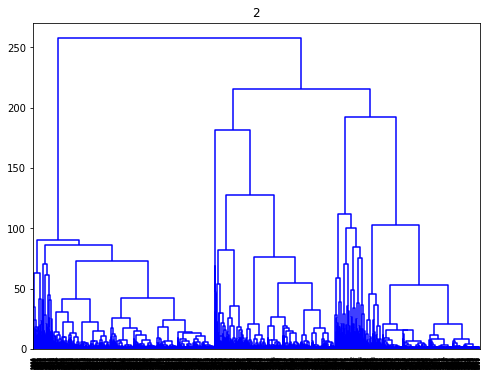

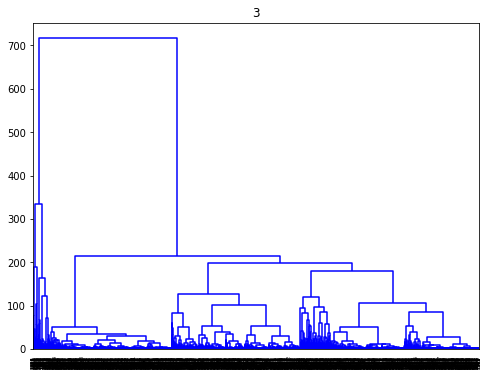

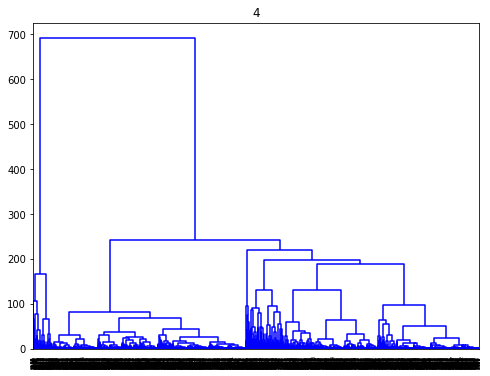

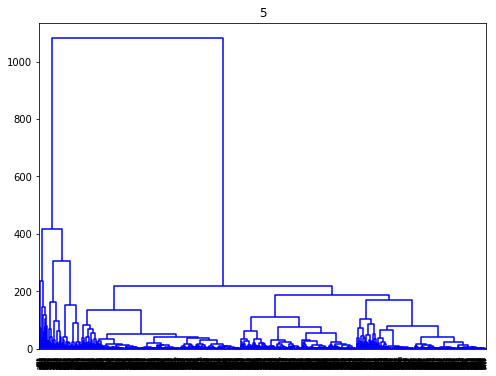

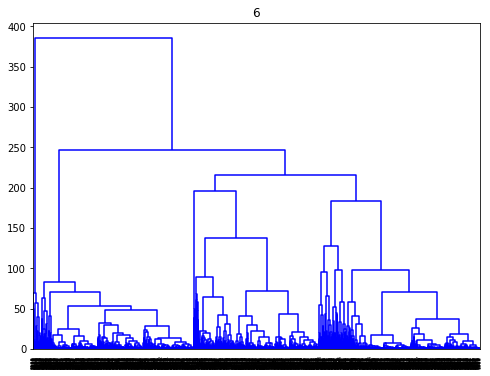

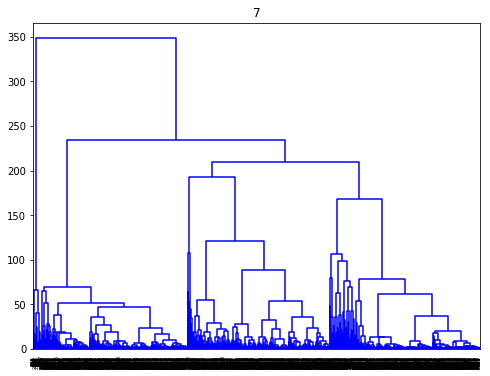

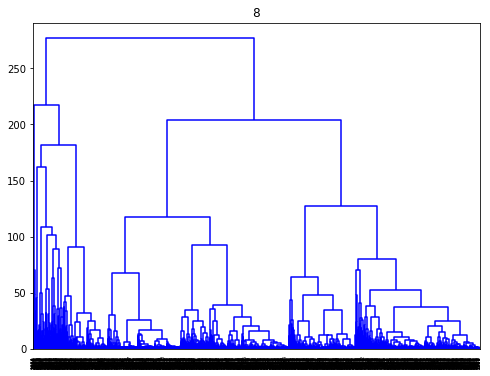

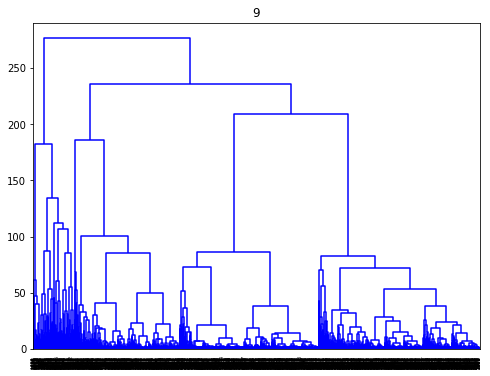

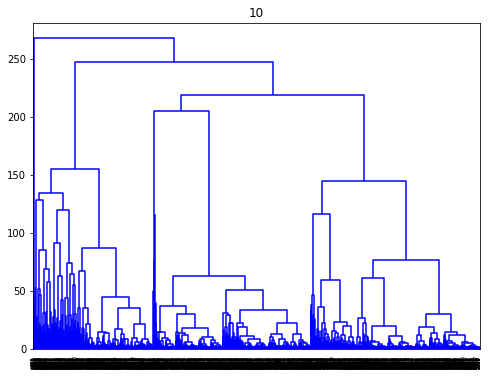

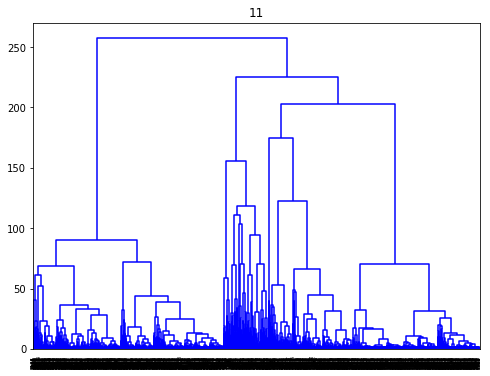

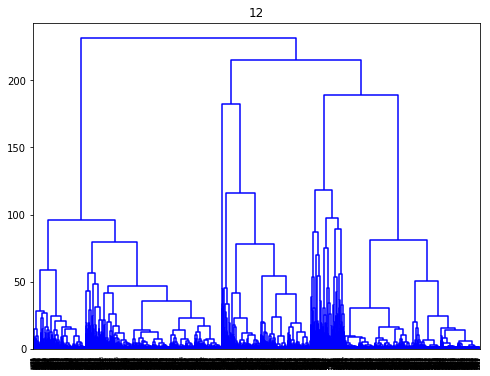

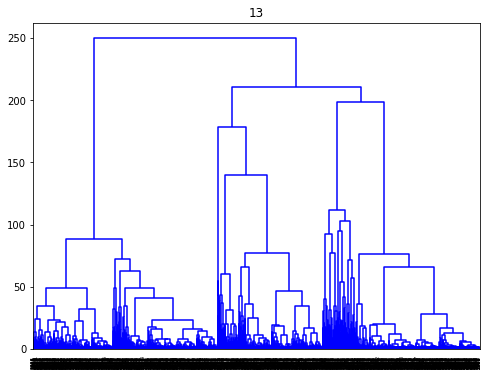

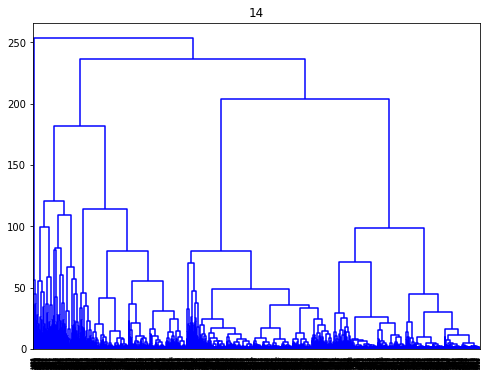

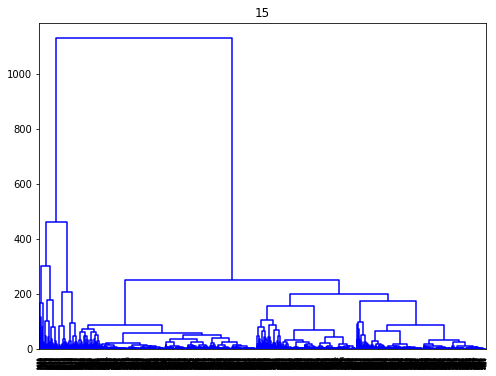

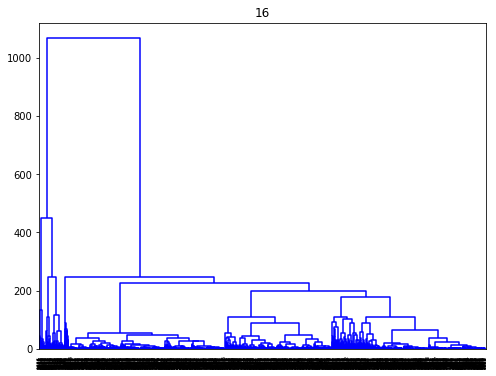

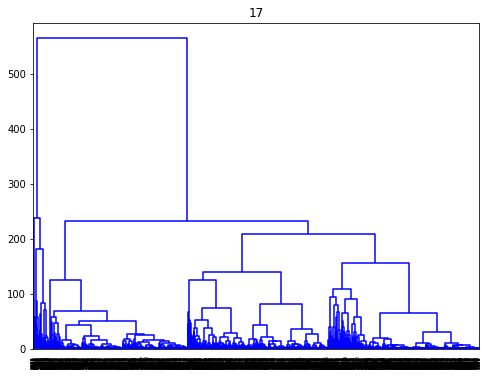

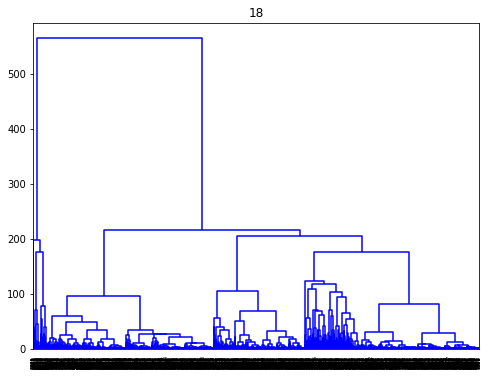

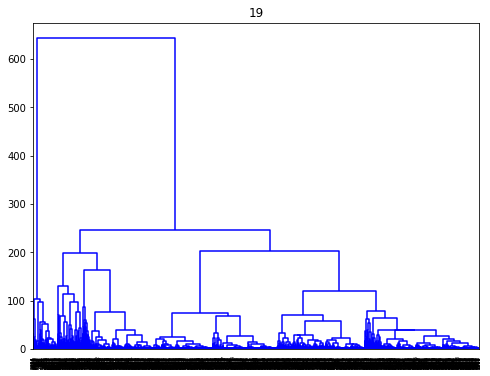

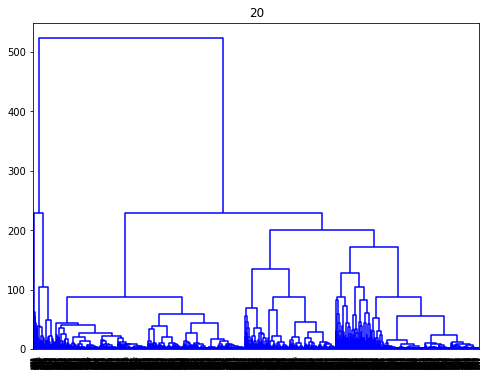

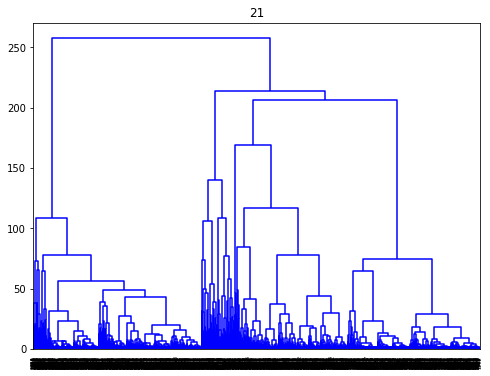

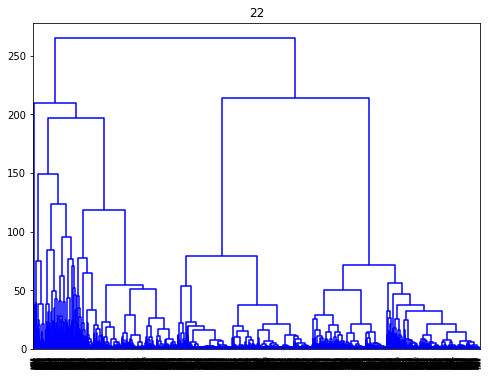

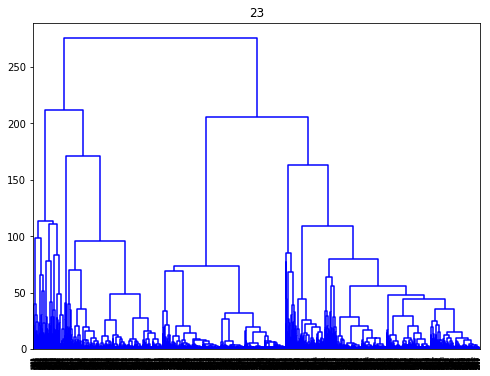

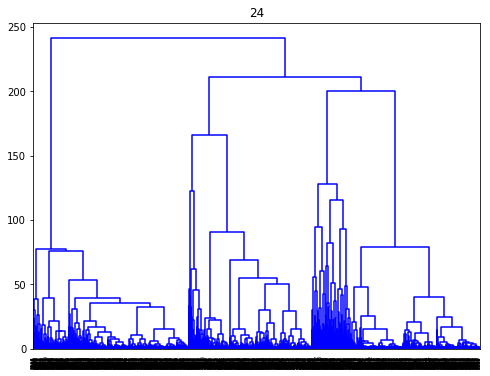

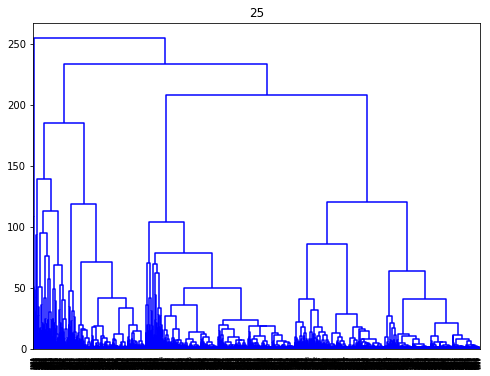

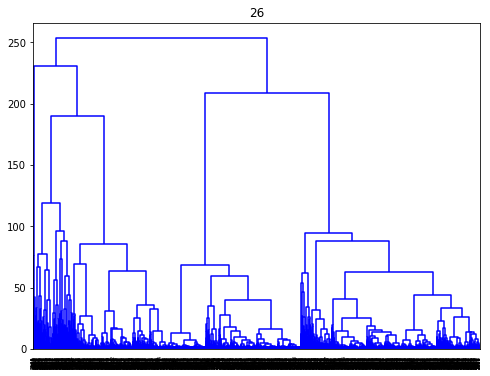

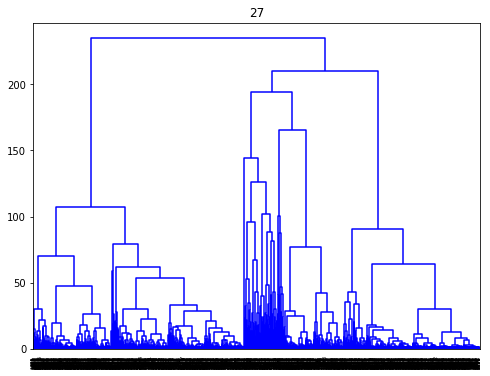

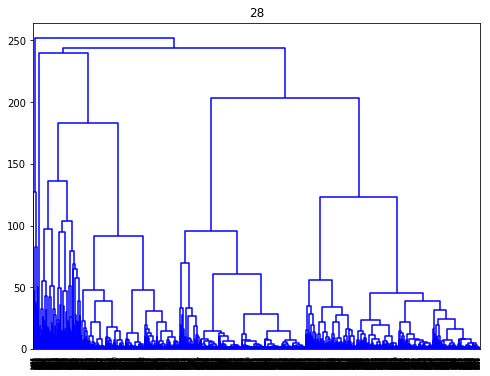

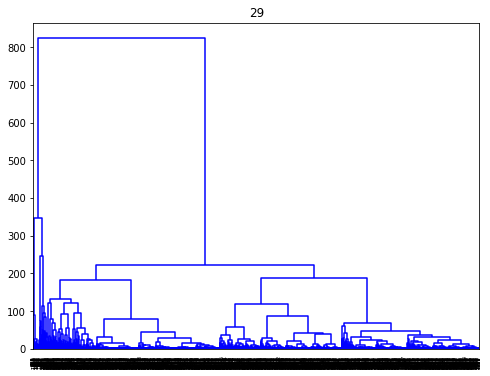

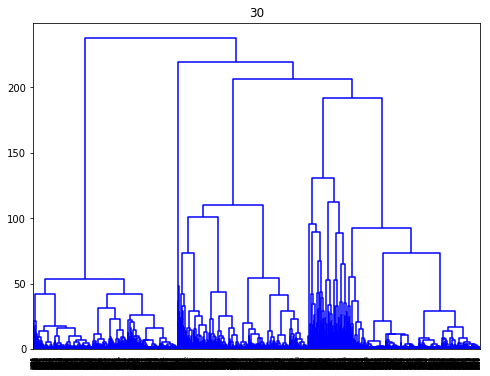

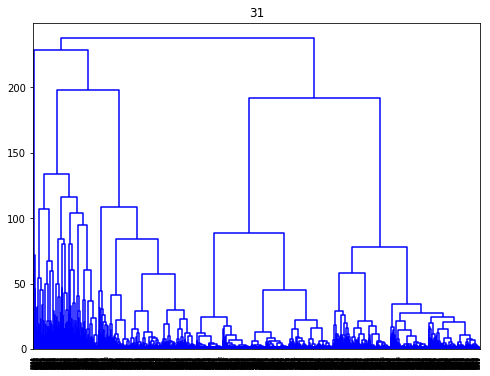

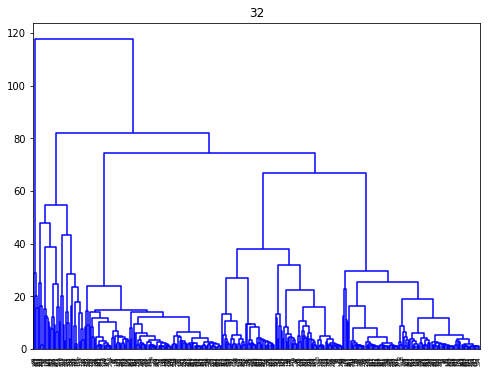

CPU times: user 12min 3s, sys: 2min 41s, total: 14min 44s
Wall time: 14min 23s


In [12]:
%%time
iclusters = np.ones(length)
try:
    for batch_number, waveform in enumerate(train_loader):
#         if batch_number==1:
#             break
        
        batch_size = waveform.size()[0]
        
        outputs = GEN(waveform.float())
        
        feature = outputs[1].view(batch_size,-1)
        feature = feature.detach().numpy()
        
        linkmatrix = fc.linkage(feature, method="ward")

        fig = plt.figure(figsize=(8, 6))
        dn = dendrogram(linkmatrix, count_sort=True, color_threshold=0)
        plt.title(batch_number)
        plt.show()
        
        clusters = fcluster(linkmatrix, 5, criterion='maxclust')
        counter = batch_number*BATCH
        iclusters[counter:counter+batch_size] = clusters
        
#         for i,j in enumerate(waveform):
#             plt.figure(figsize=(8,6))
#             plt.plot(waveform[i][0].detach().numpy(),label="heat")
#             plt.plot(waveform[i][1].detach().numpy(),label="light")
#             plt.legend()
#             plt.title("{}".format(clusters[i]))
#             plt.show()
        
except KeyboardInterrupt:
    print('Training ended early.')

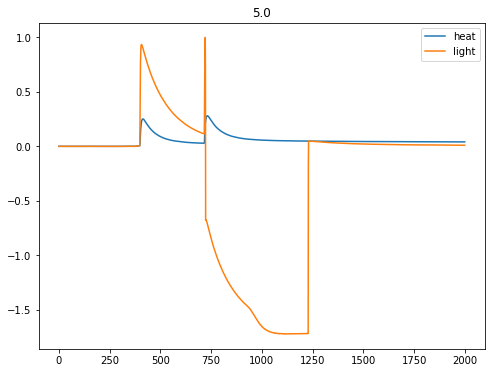

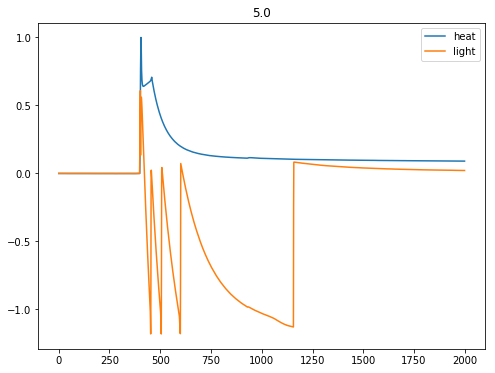

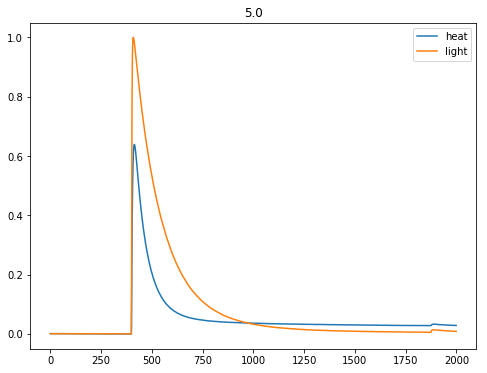

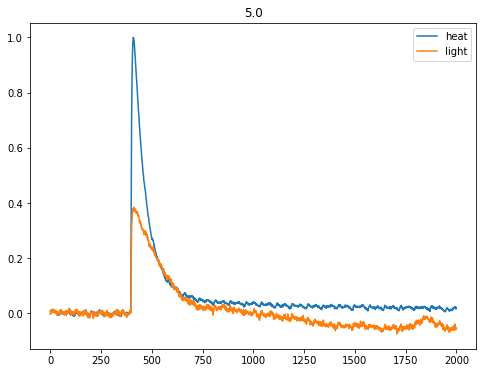

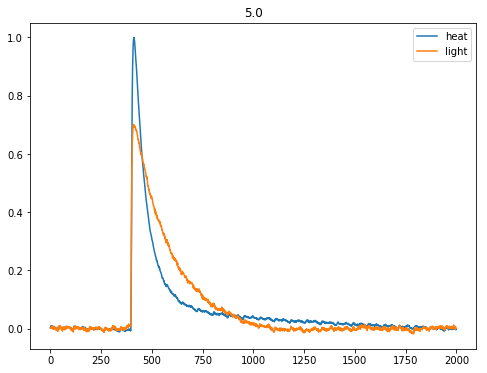

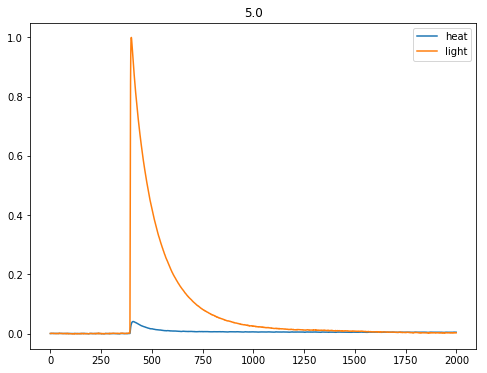

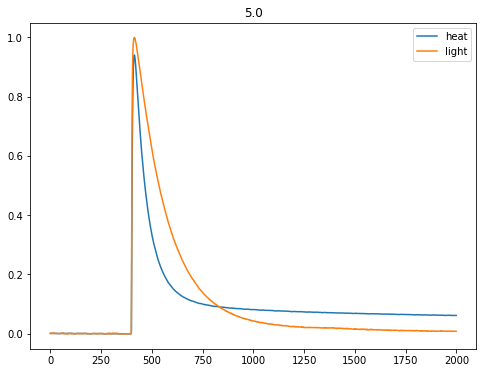

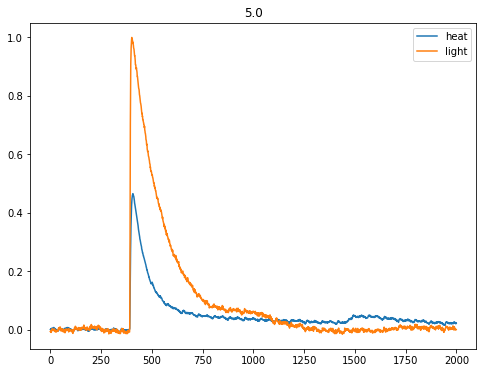

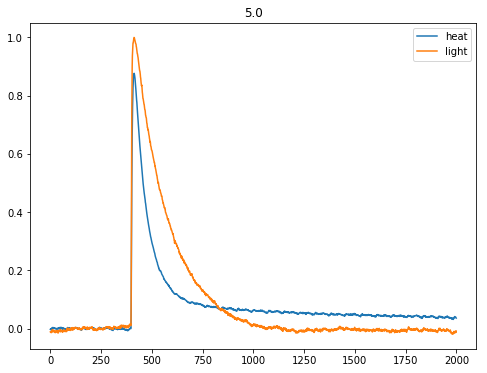

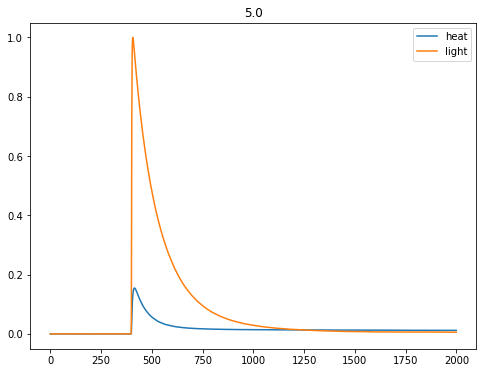

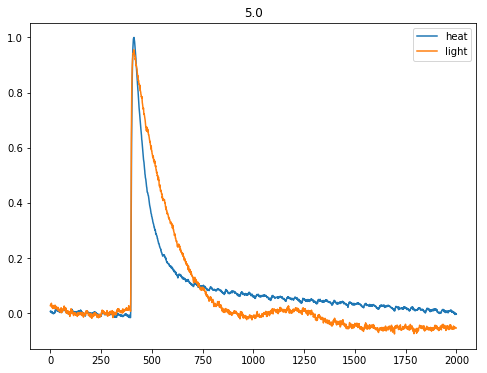

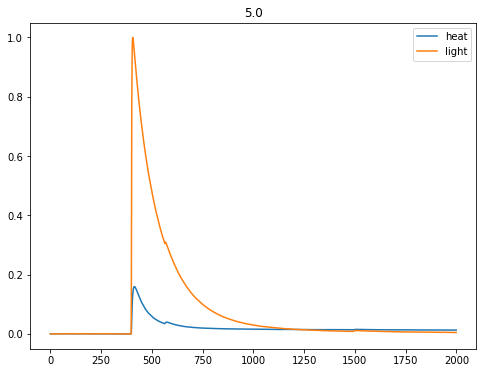

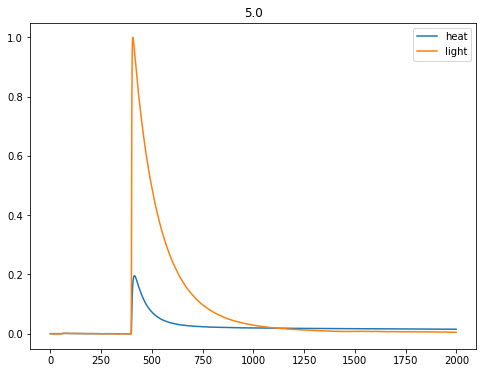

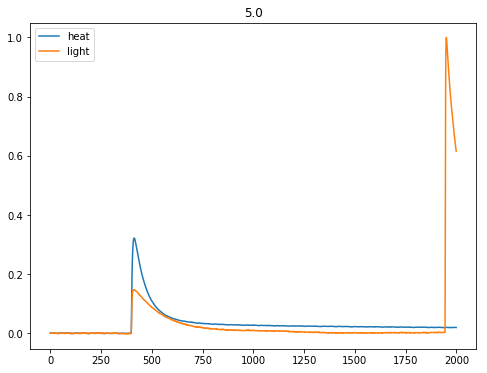

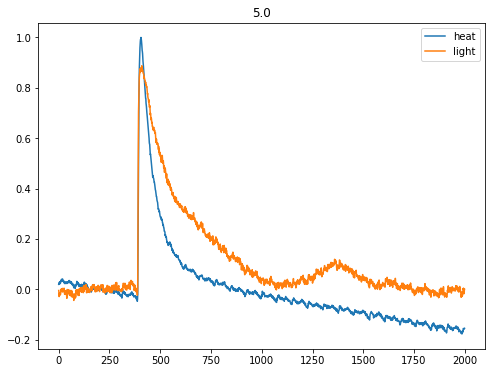

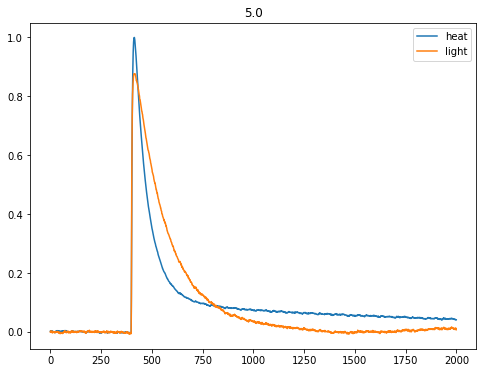

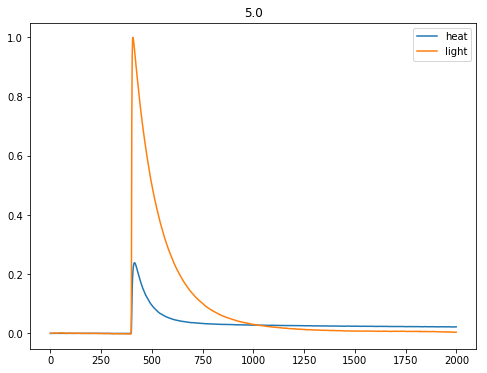

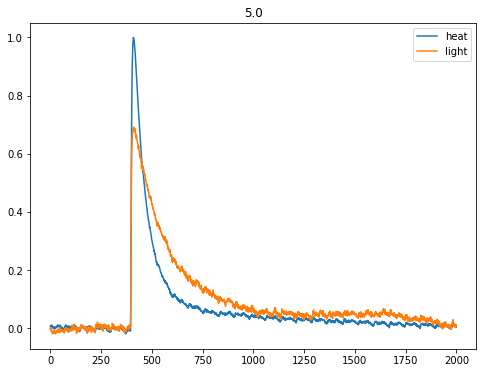

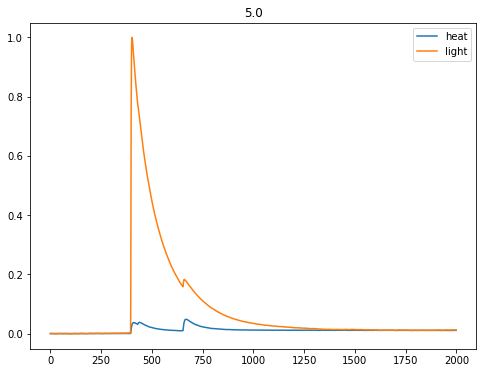

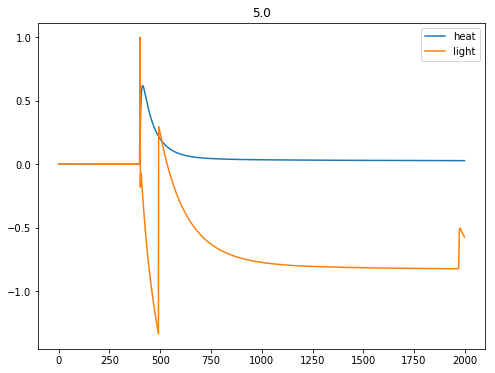

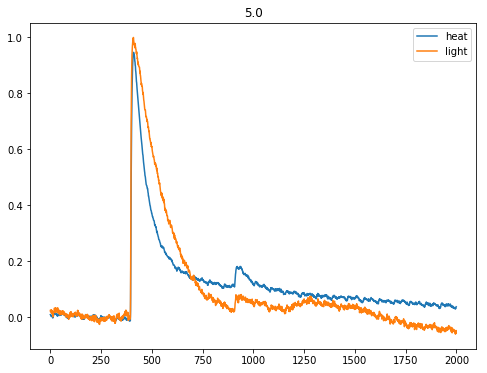

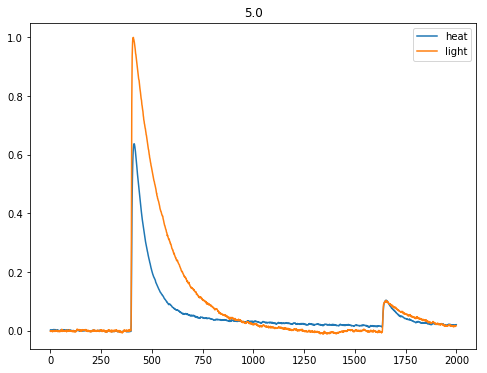

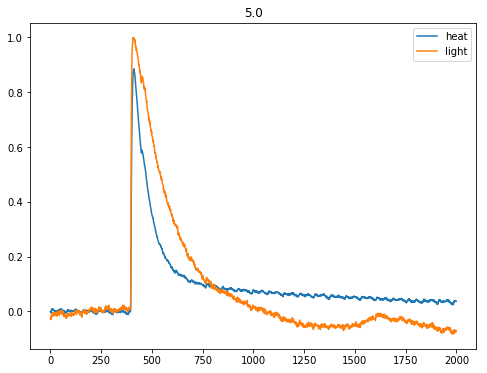

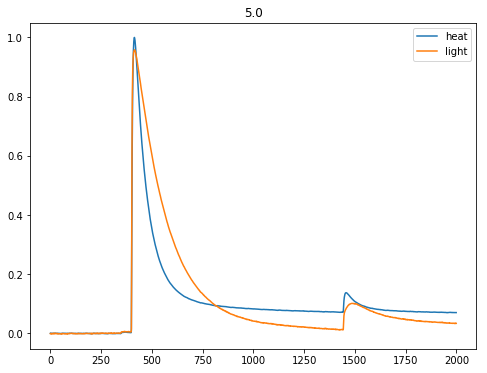

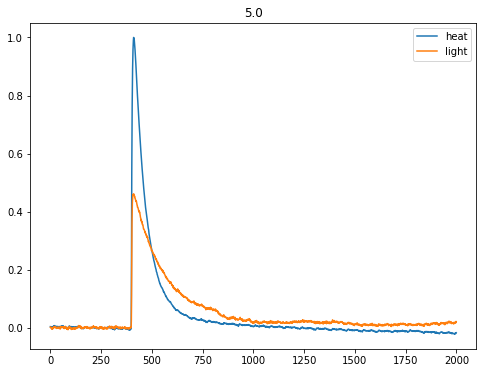

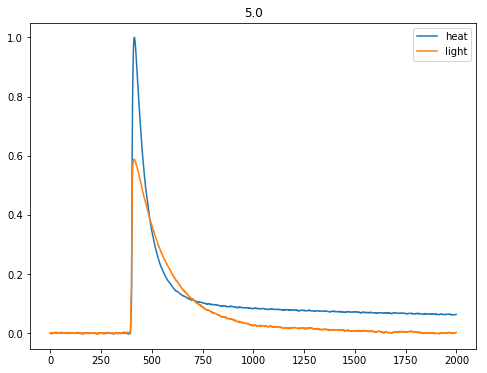

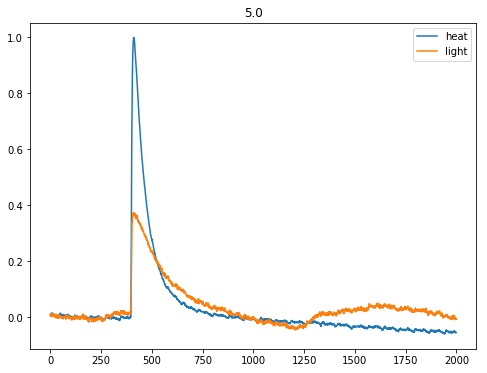

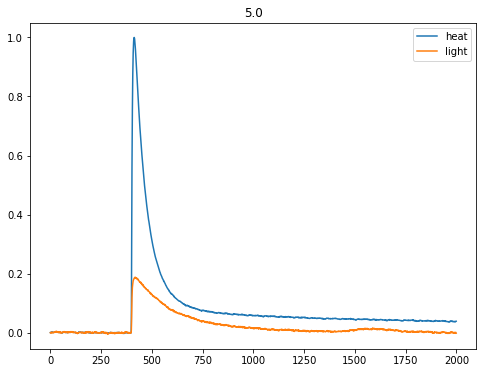

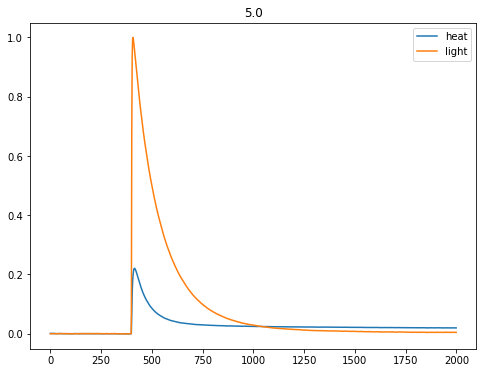

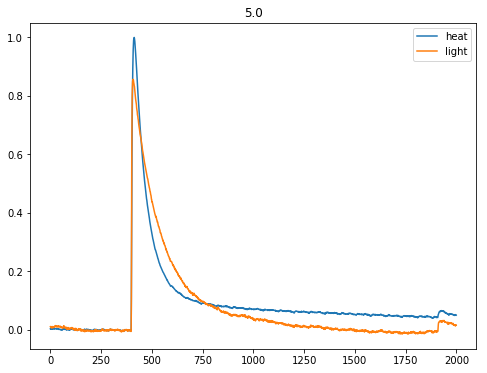

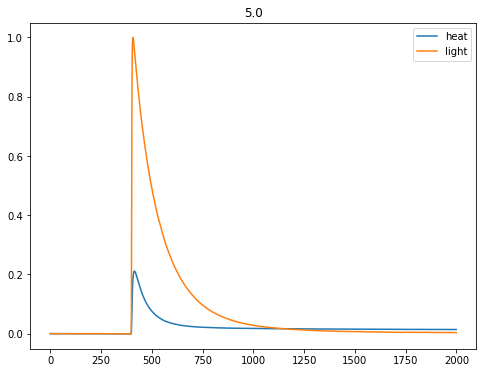

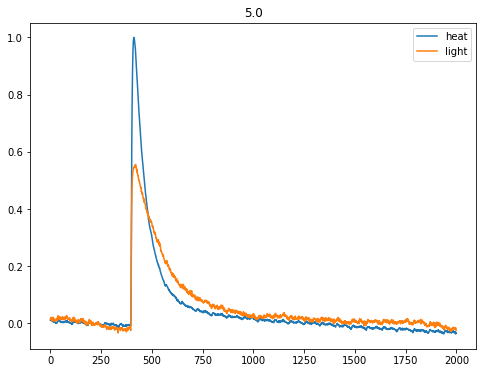

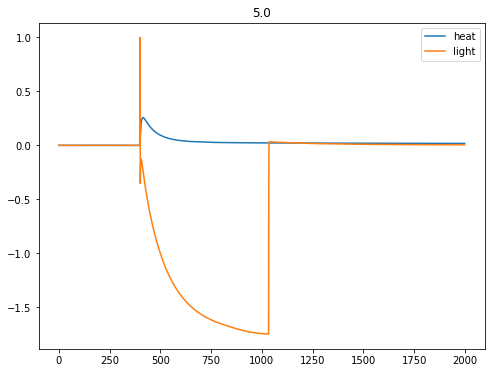

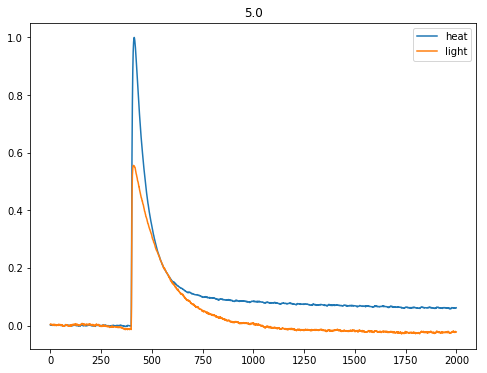

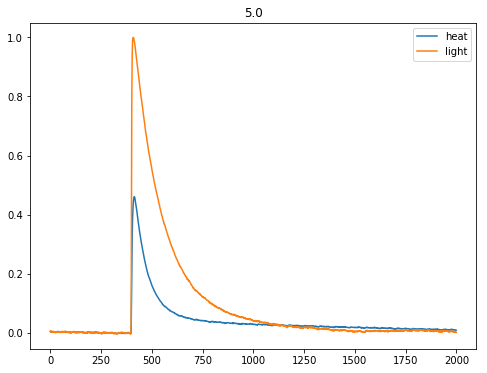

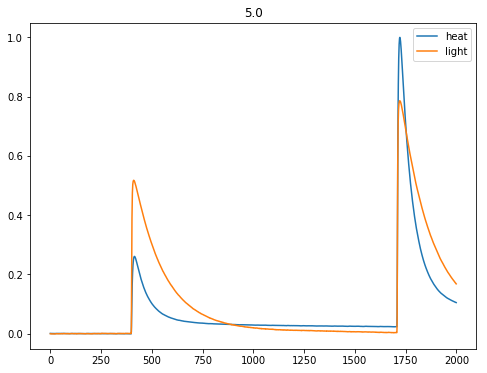

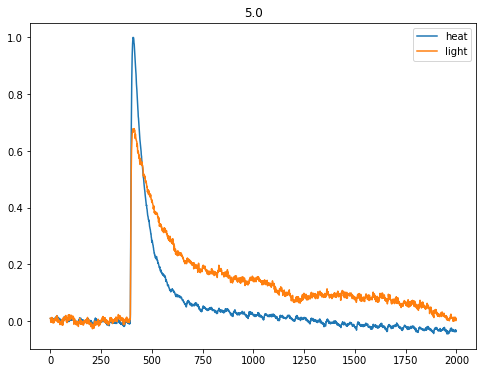

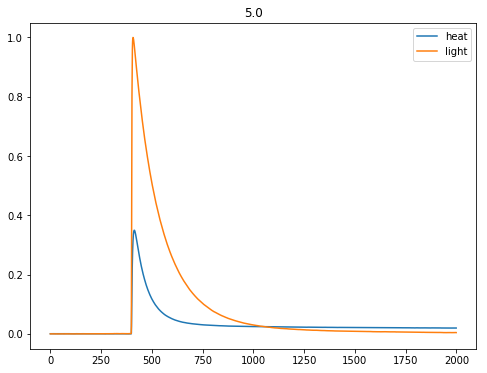

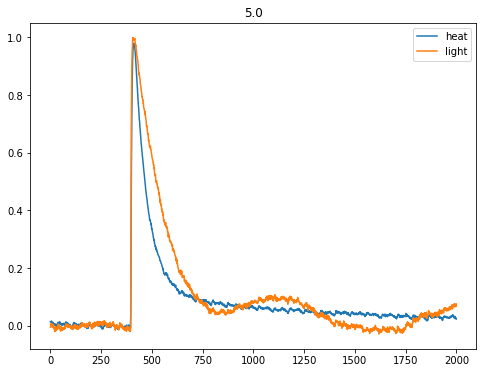

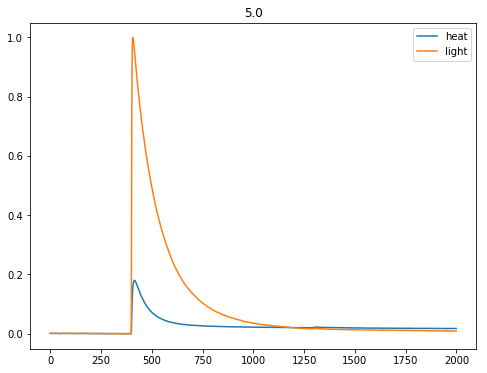

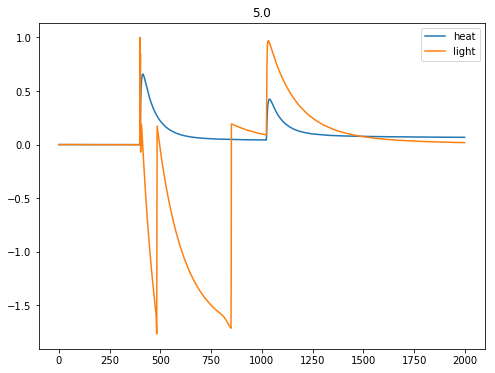

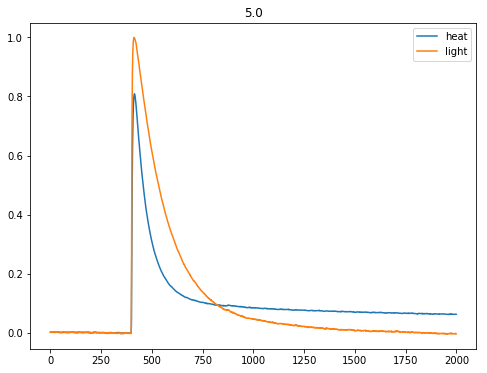

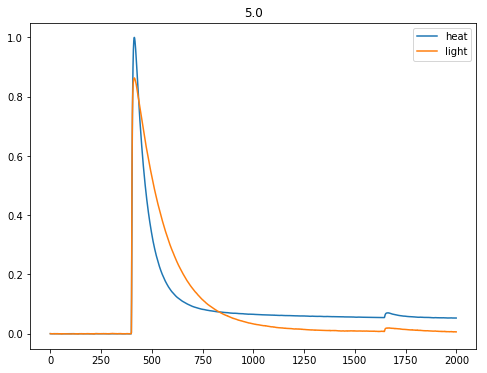

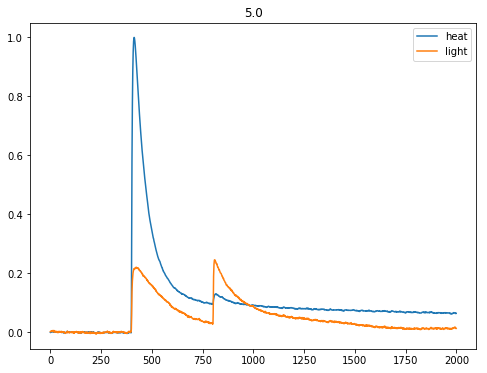

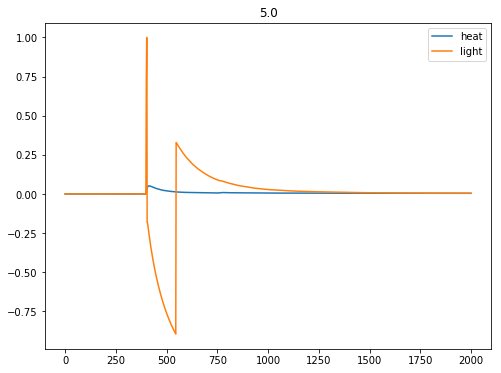

Process Process-3:
Process Process-4:


Training ended early.


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = in

In [10]:
group = 5
try:
    for batch_number, waveform in enumerate(train_loader):
        
        for i,j in enumerate(waveform):
            if iclusters[i] == group:
                plt.figure(figsize=(8,6))
                plt.plot(waveform[i][0].detach().numpy(),label="heat")
                plt.plot(waveform[i][1].detach().numpy(),label="light")
                plt.legend()
                plt.title("{}".format(iclusters[i]))
                plt.show()
            else:
                continue

except KeyboardInterrupt:
    print('Training ended early.')

Group 1 !!!!!


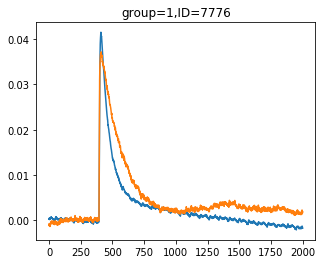

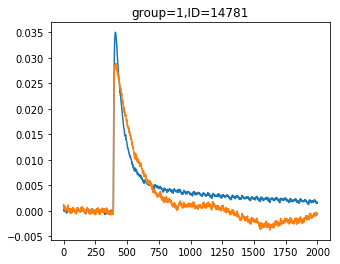

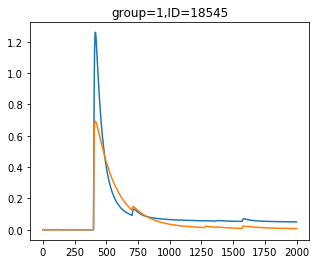

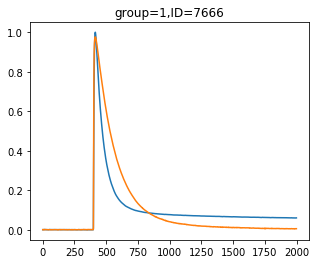

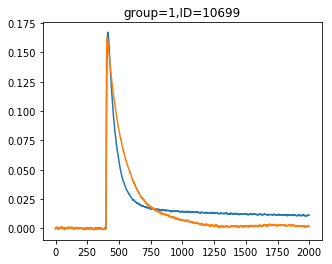

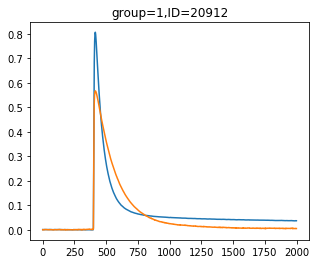

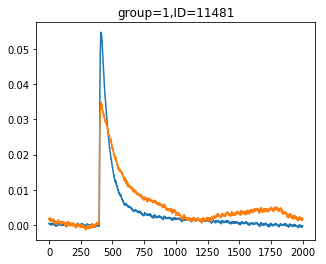

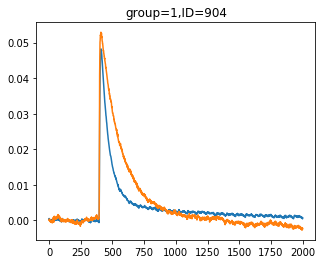

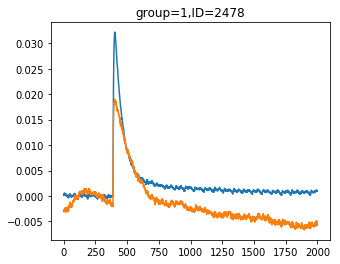

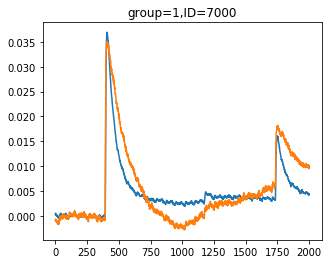

Group 2 !!!!!


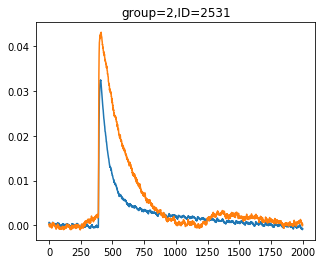

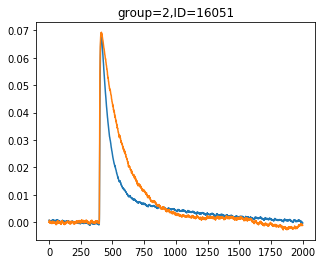

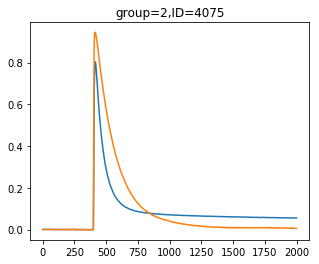

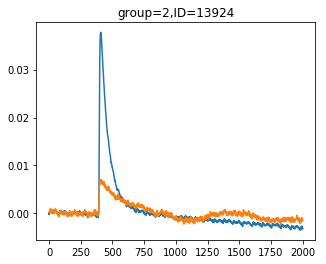

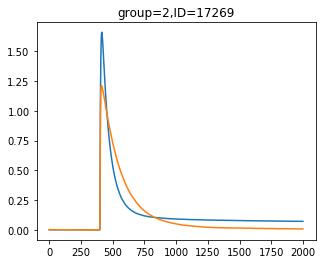

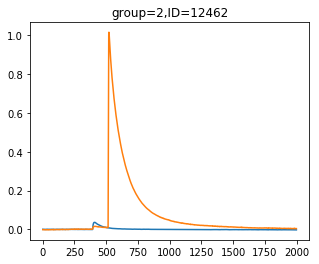

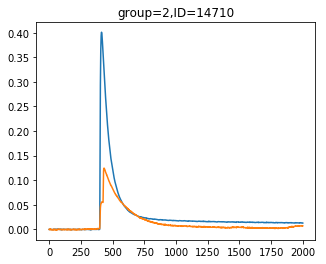

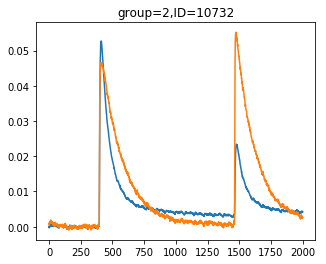

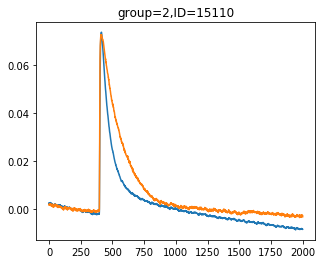

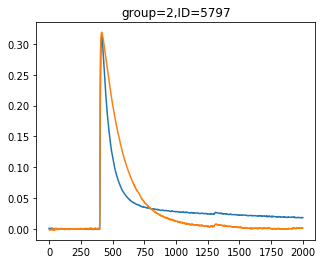

Group 3 !!!!!


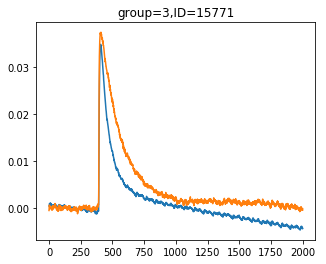

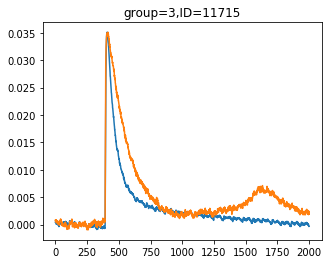

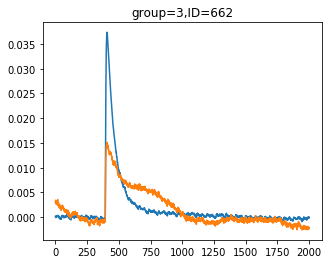

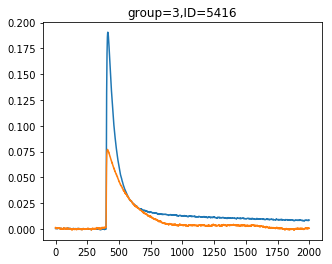

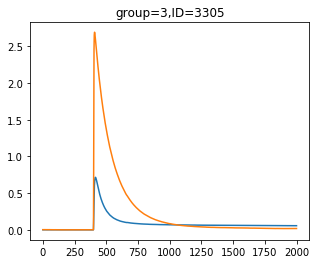

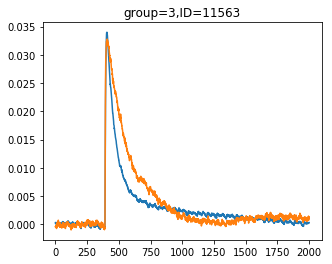

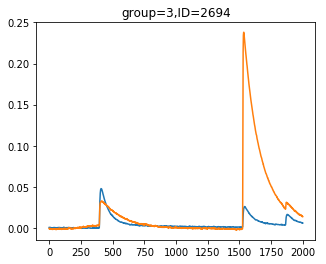

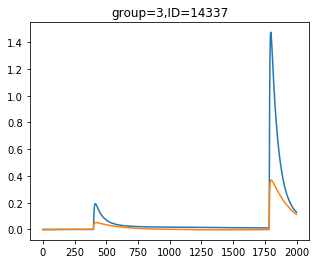

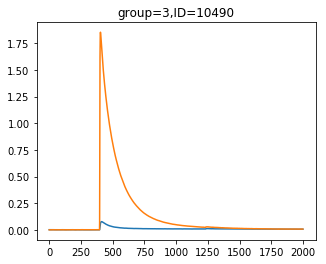

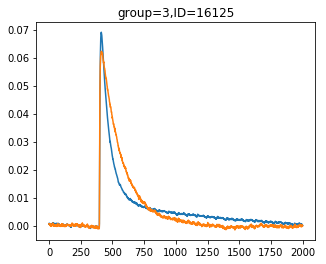

Group 4 !!!!!


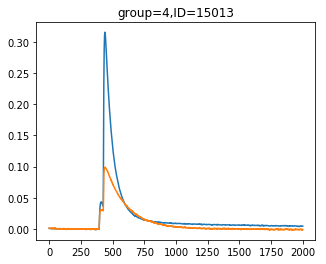

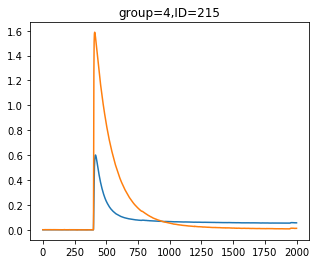

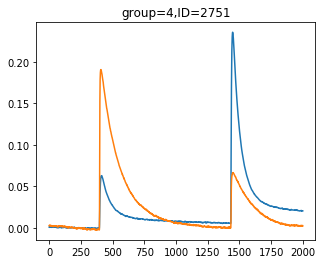

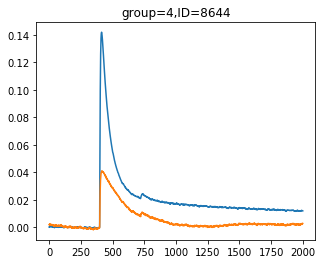

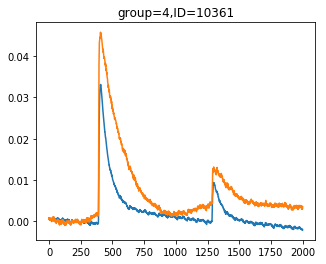

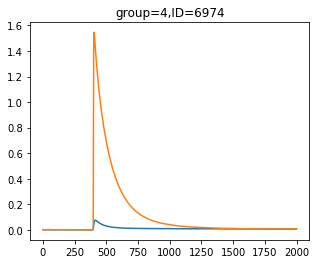

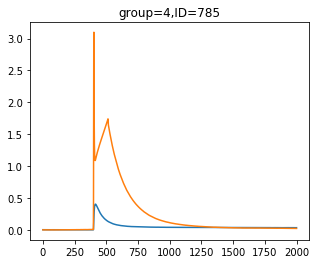

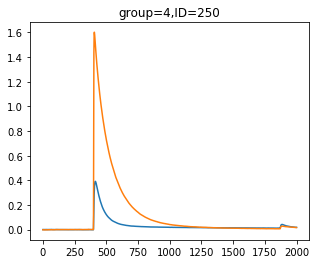

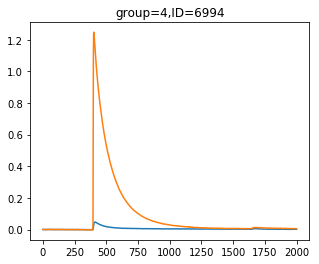

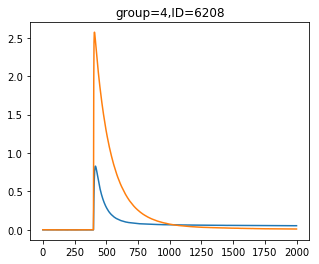

Group 5 !!!!!


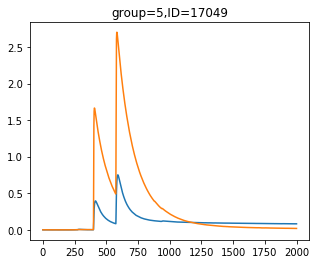

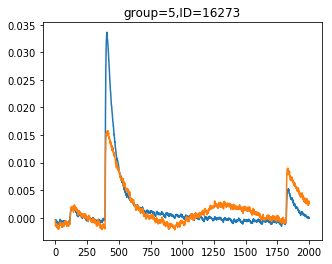

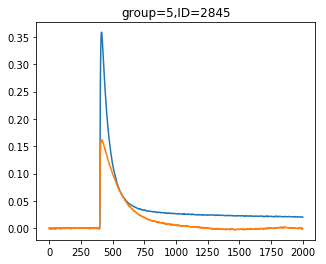

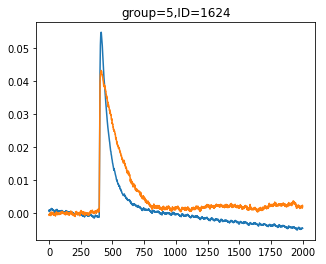

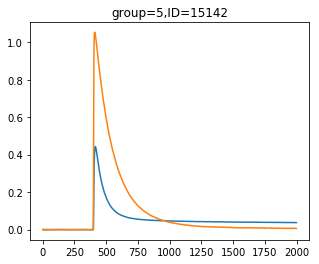

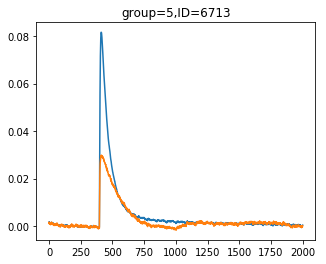

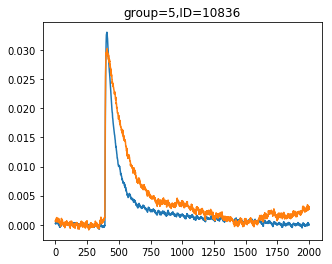

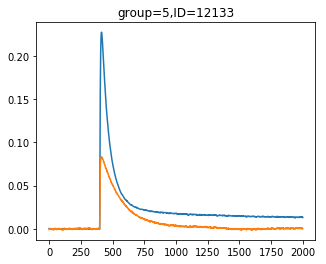

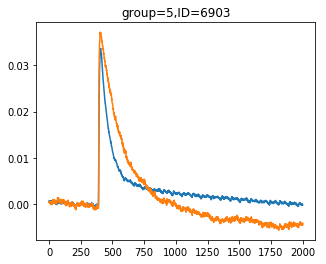

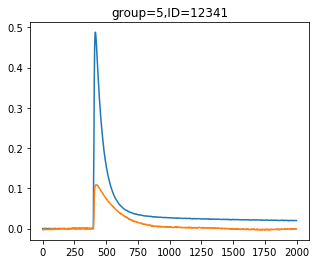

In [13]:
for group in np.arange(1,6,1):
    print("Group {} !!!!!".format(group))
    for i,j in enumerate(Phonon[iclusters==group]):
        heat = Phonon[iclusters==group]
        light = Photon[iclusters==group]
        rou = np.random.randint(len(light))
        if i==10:
            break
        plt.figure(figsize=(5,4))
        plt.plot(heat[rou], label="heat")
        plt.plot(light[rou], label="light")
        plt.title("group={},ID={}".format(group,eventid[rou]))
        plt.show()

<Figure size 720x576 with 0 Axes>

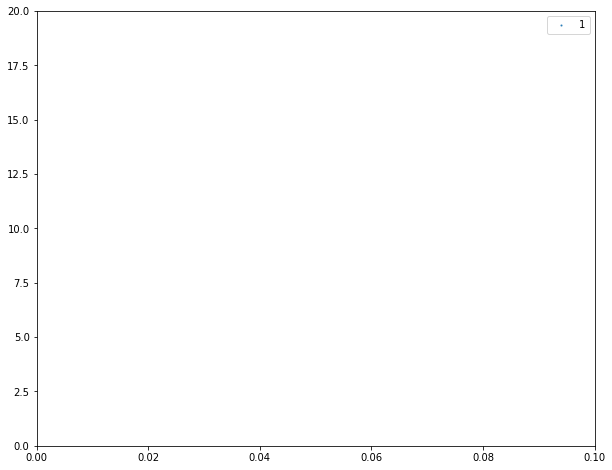

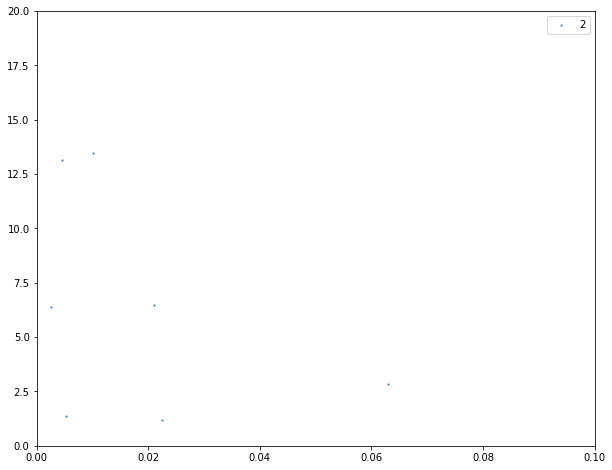

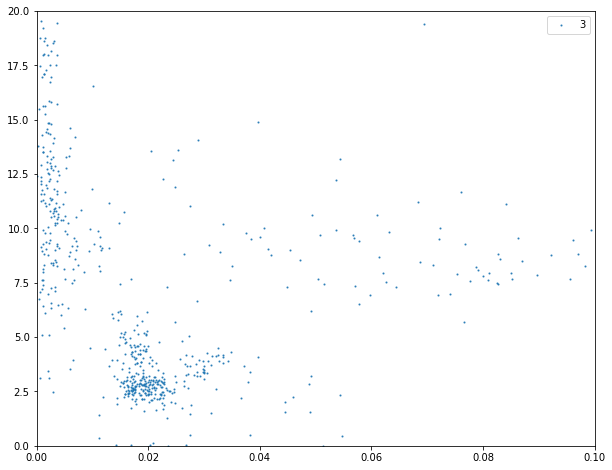

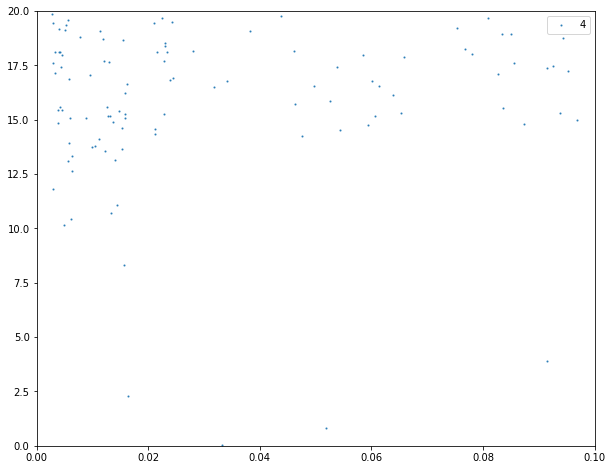

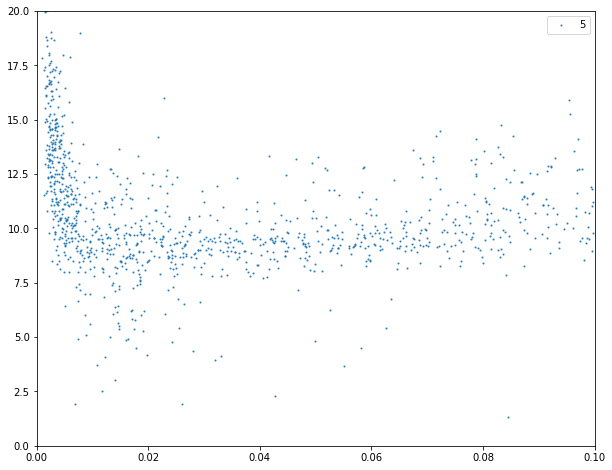

In [21]:
x = energy_heat1[:3000]
y = ratio1[:3000]
plt.figure(figsize=(10,8))
for group in np.arange(1,6,1):
    plt.figure(figsize=(10,8))
    plt.scatter(x[iclusters[:3000]==group], y[iclusters[:3000]==group],
                alpha=0.8, marker=".", s=5, label="{}".format(group))
    plt.xlim(0,0.1)
    plt.ylim(0,20)
    #     plt.title("{}".format(group))
    plt.legend()
    plt.show()

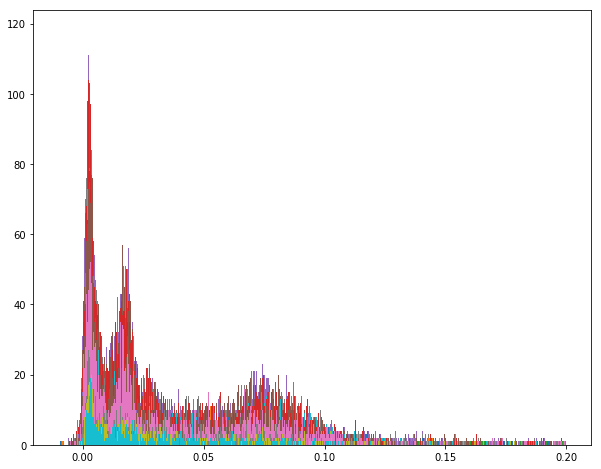

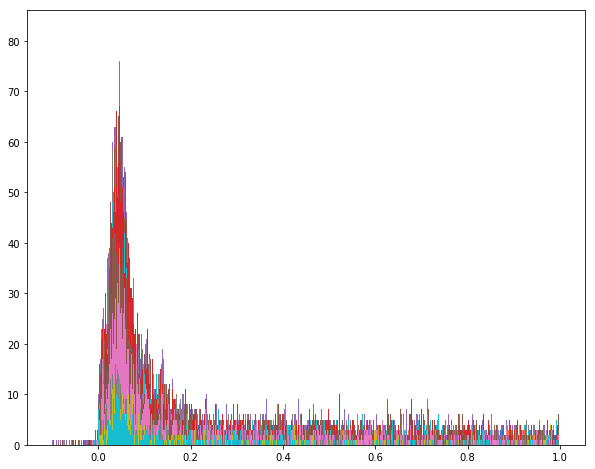

In [15]:
plt.figure(figsize=(10,8))
for group in np.arange(1,6,1):
    plt.hist(energy_heat[iclusters==group],bins=np.arange(-0.01,0.2,0.0002))
#     plt.yscale("log")
plt.show()

plt.figure(figsize=(10,8))
for group in np.arange(1,31,1):
    plt.hist(energy_light[iclusters==group],bins=np.arange(-0.1,1,0.001))
#     plt.yscale("log")
plt.show()

In [11]:
%%time

group = 28

def funcd(t, A0, A1, d0, d1):
    t = t*1e-4
    A0 > A1
    d0 > d1
    d0,d1 > A0,A1
#     d0 > A0
#     d1 > A1
    
    y1 = A0*(np.exp(-t/d0))
    y2 = A1*(np.exp(-t/d1))
    return y1+y2

parameters = np.empty((length,4))
parameters2 = np.empty((length,3))

x1 = np.arange(0, 100, 1)
x2 = np.arange(0, 200, 1)

for i,j in enumerate(Phonon):
    start = start_heat_max[i]+15
    popt, pcov = curve_fit(funcd, x1, j[start:(start+100)], 
                           maxfev=5000, bounds=(0,[10,10,np.Inf,np.Inf]))
    parameters[i] = popt
    
    x_plot = np.arange(start,start+300,1)
    y_plot = np.arange(0,300,1)
    istart=start_heat_min[i]

    def func(t, r0, r1, A2):
        t = t*1e-4
        iA0, iA1 ,id0, id1 = popt
#         A2 < iA0
#         A2 < iA1
#         A2 > 0.1*energy_heat[i]
        iA2 = A2*energy_heat[i]
        
#         r0 > r1
#         r0 < id0
#         r1 < id1
#         energy_heat[i] =A2+iA0+iA1

        y1 = (iA0+iA2)*(-np.exp(-t/r0)+np.exp(-t/id0))
        y2 = (iA1+iA2)*(-np.exp(-t/r1)+np.exp(-t/id1))
        y3 = iA2*(-np.exp(-t/r0)-np.exp(-t/r1))
        return y1+y2+y3
    
    ipopt, ipcov = curve_fit(func, x2, j[int(istart):int(istart+200)], maxfev=5000,
                             bounds=([0, 0, 0],[np.Inf, np.Inf, 0.3]))
    parameters2[i]=ipopt
    
    ix_plot = np.arange(istart,istart+500,1)
    iy_plot = np.arange(0,500,1)
    
#     plt.figure(figsize=(6,5))
#     plt.plot(j, label = "data")
#     plt.plot(x_plot,funcd(y_plot,popt[0],popt[1],popt[2],popt[3]), label="fit_p")
#     plt.plot(ix_plot,func(iy_plot,ipopt[0],ipopt[1],ipopt[2]), label="fit")
#     plt.xlim(380,600)
#     plt.legend()
#     plt.show()
#     print(popt)
#     print(ipopt)
#     if i==100:
#         break

CPU times: user 2h 26min 44s, sys: 1.18 s, total: 2h 26min 45s
Wall time: 2h 27min 13s


In [12]:
np.save("fit1.npy",parameters)
np.save("fit2.npy",parameters2)

In [15]:
del parametermeters, parameter, parameters2

In [22]:
parameters = np.load("fit1.npy")
parameters2 = np.load("fit2.npy")

In [23]:
test = np.concatenate((parameters[:3],parameters2[:3]),axis=1)
print(test.shape)

(3, 7)


torch.Size([3000, 256]) (3000, 7)


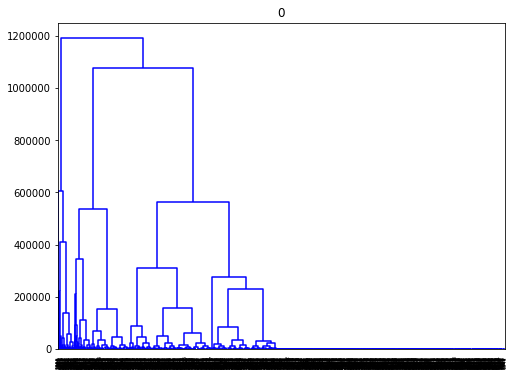

torch.Size([3000, 256]) (3000, 7)


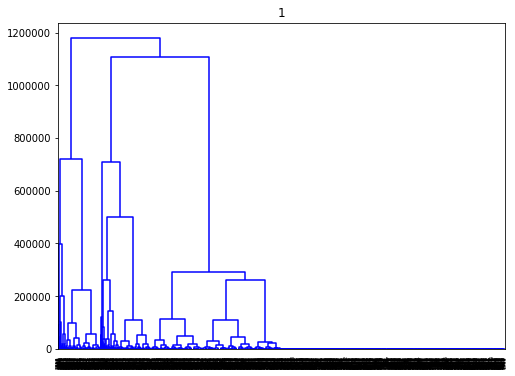

torch.Size([3000, 256]) (3000, 7)


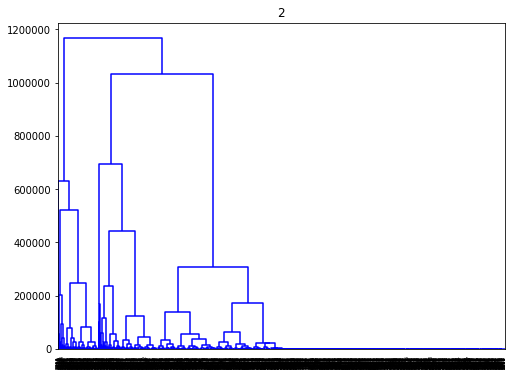

torch.Size([3000, 256]) (3000, 7)


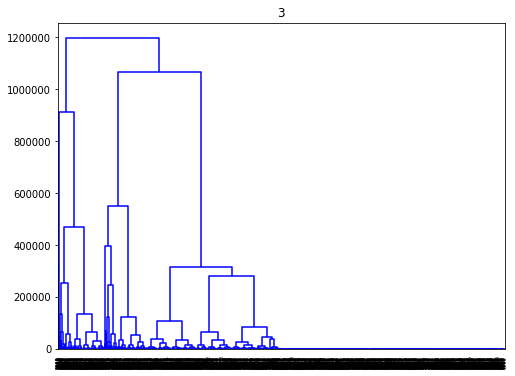

torch.Size([3000, 256]) (3000, 7)


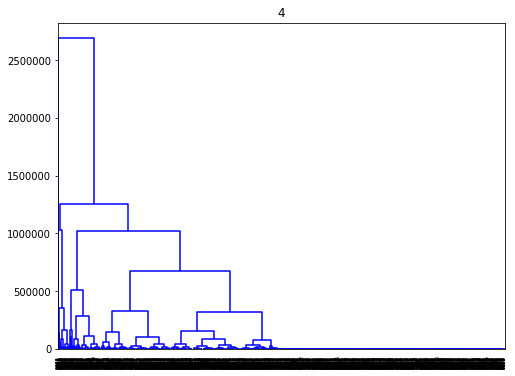

torch.Size([3000, 256]) (3000, 7)


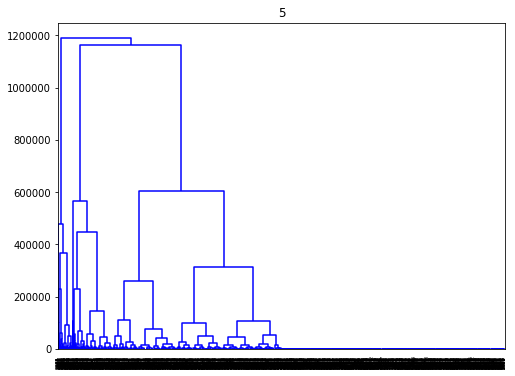

torch.Size([3000, 256]) (3000, 7)


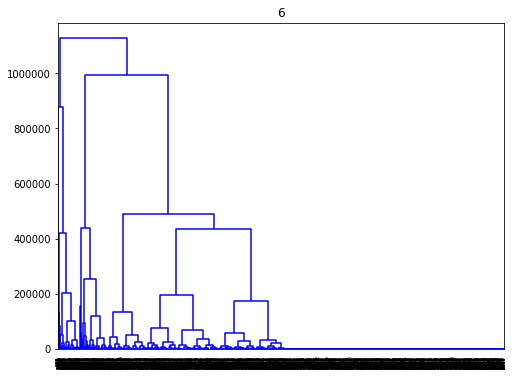

torch.Size([3000, 256]) (3000, 7)


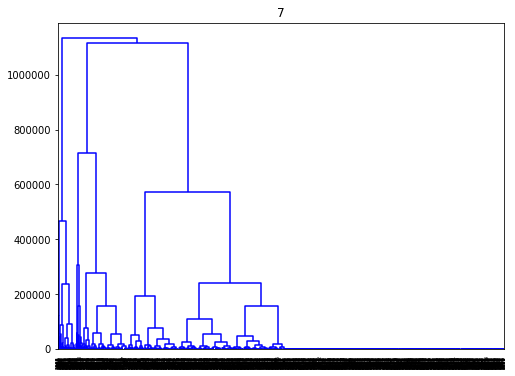

torch.Size([3000, 256]) (3000, 7)


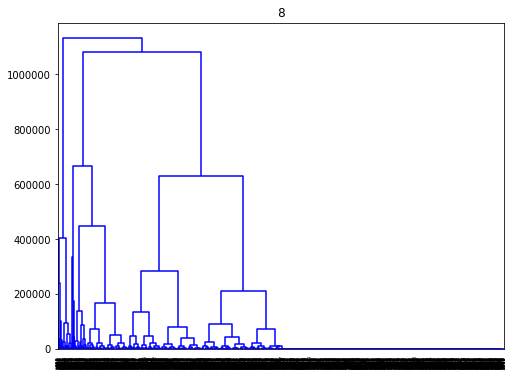

torch.Size([3000, 256]) (3000, 7)


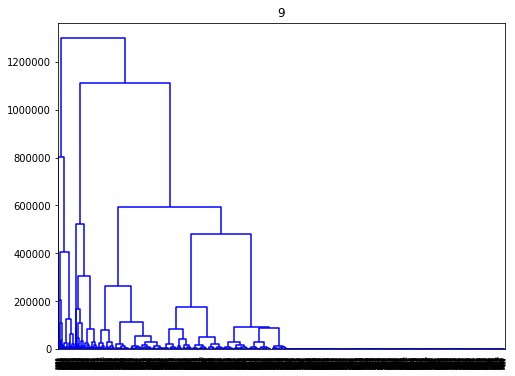

torch.Size([3000, 256]) (3000, 7)


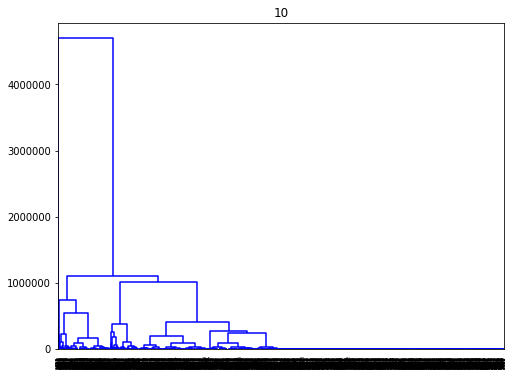

torch.Size([3000, 256]) (3000, 7)


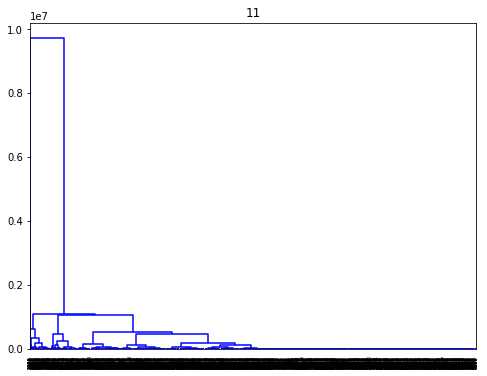

torch.Size([3000, 256]) (3000, 7)


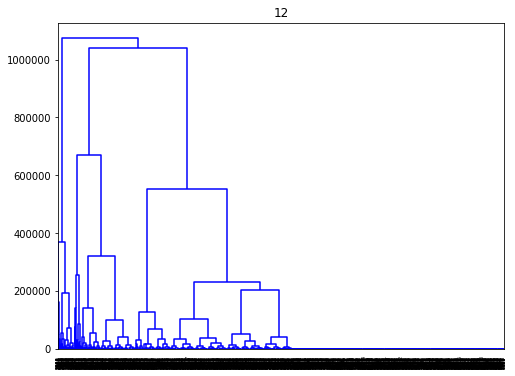

torch.Size([3000, 256]) (3000, 7)


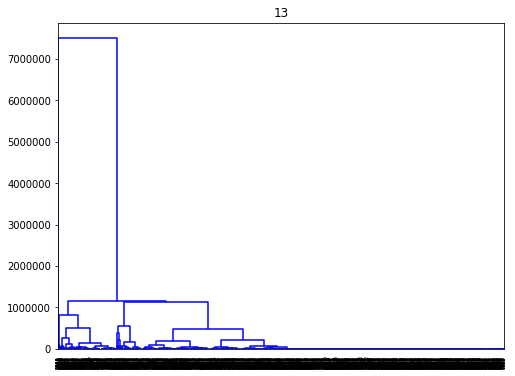

torch.Size([3000, 256]) (3000, 7)


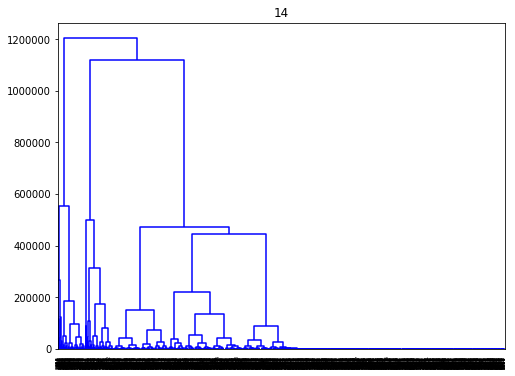

torch.Size([3000, 256]) (3000, 7)


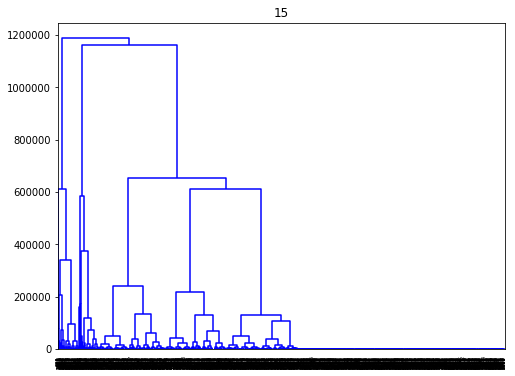

torch.Size([3000, 256]) (3000, 7)


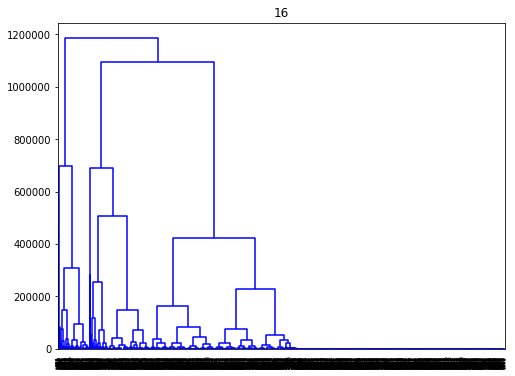

torch.Size([3000, 256]) (3000, 7)


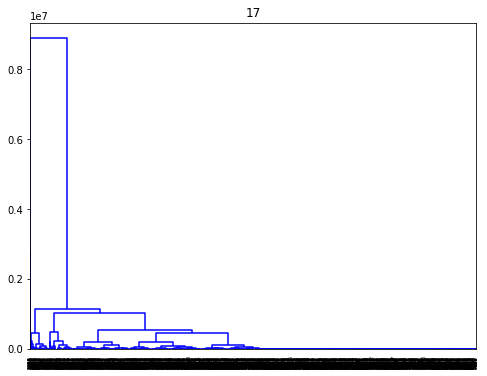

torch.Size([3000, 256]) (3000, 7)


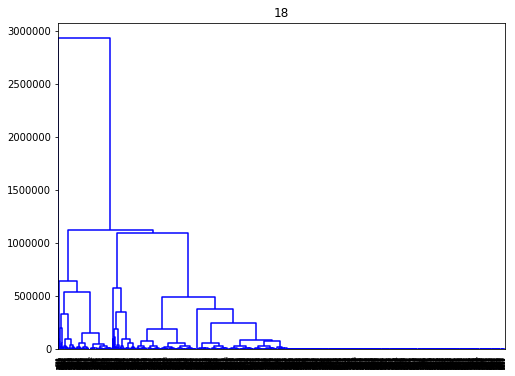

torch.Size([3000, 256]) (3000, 7)


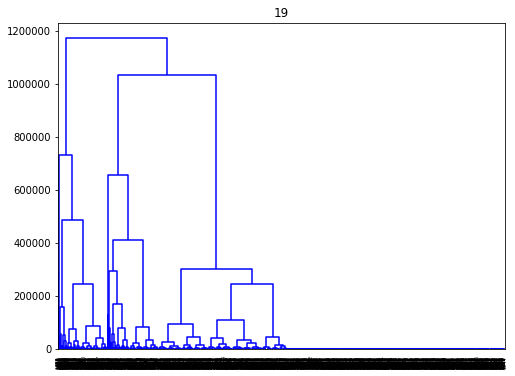

torch.Size([3000, 256]) (3000, 7)


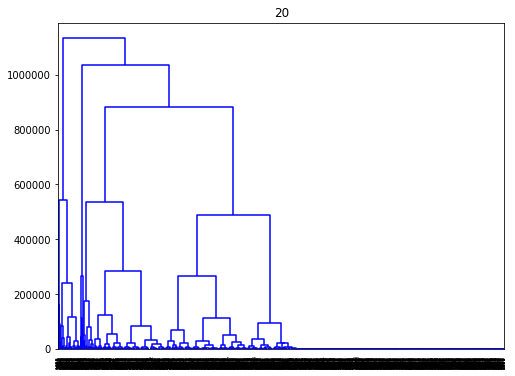

torch.Size([3000, 256]) (3000, 7)


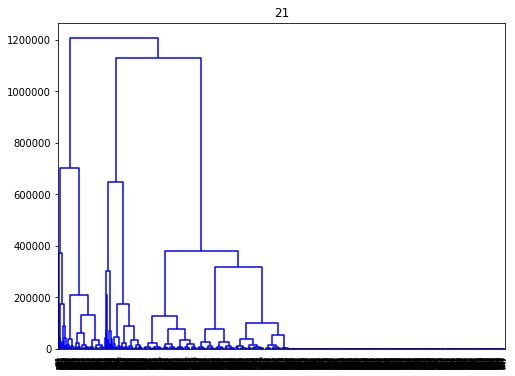

torch.Size([3000, 256]) (3000, 7)


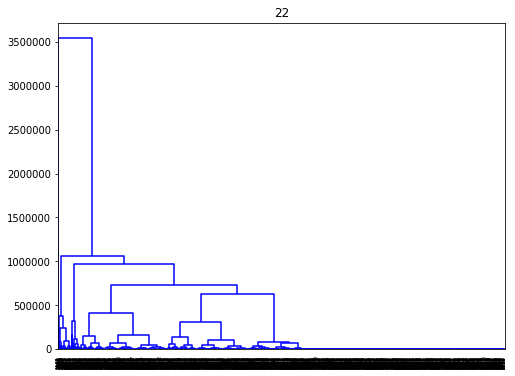

torch.Size([3000, 256]) (3000, 7)


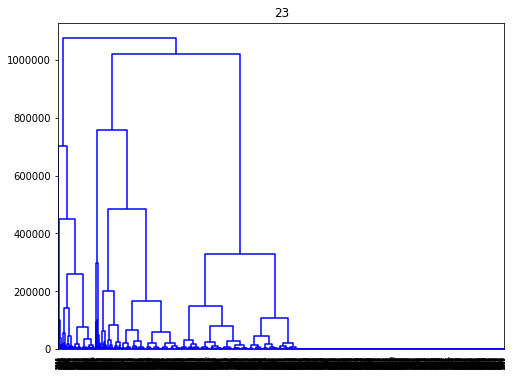

torch.Size([3000, 256]) (3000, 7)


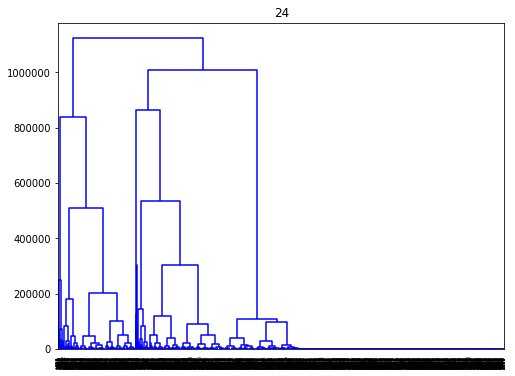

torch.Size([3000, 256]) (3000, 7)


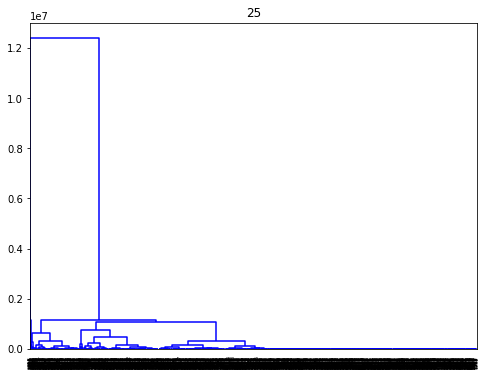

torch.Size([3000, 256]) (3000, 7)


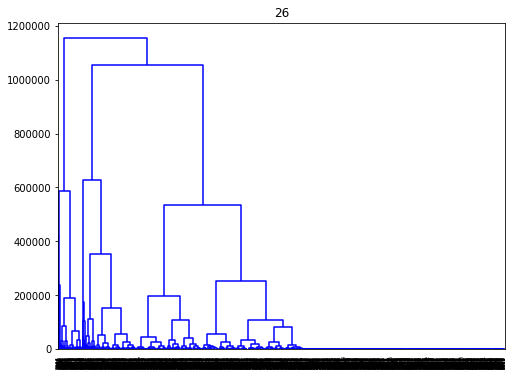

torch.Size([3000, 256]) (3000, 7)


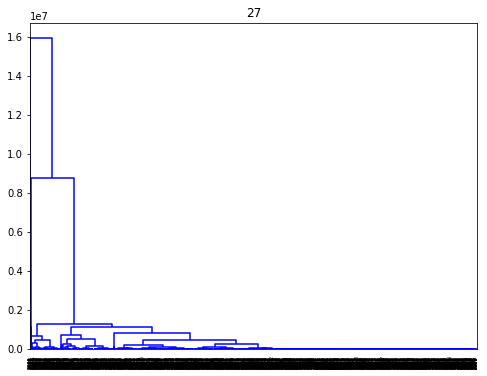

torch.Size([3000, 256]) (3000, 7)


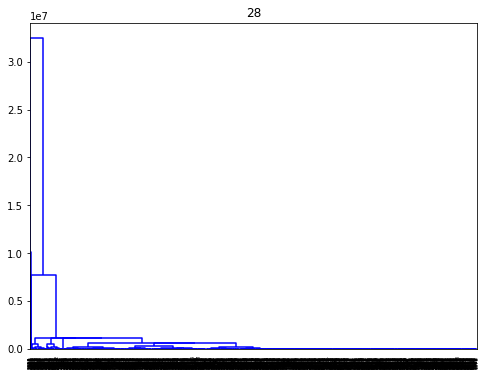

torch.Size([3000, 256]) (3000, 7)


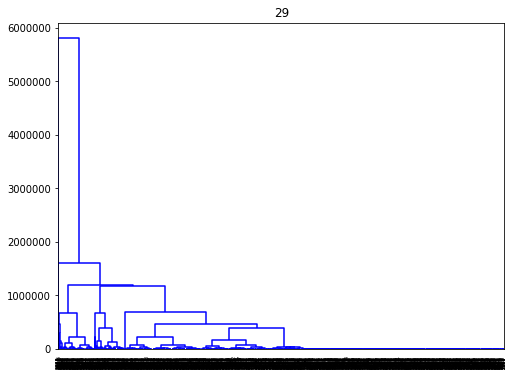

torch.Size([3000, 256]) (3000, 7)


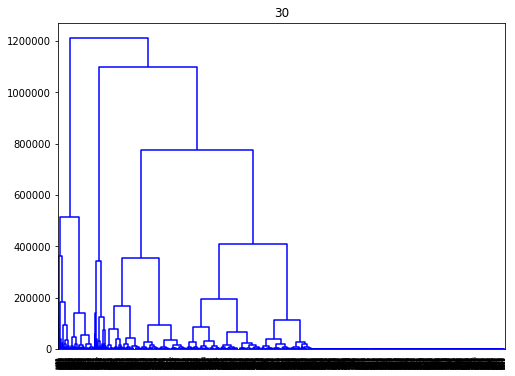

torch.Size([3000, 256]) (3000, 7)


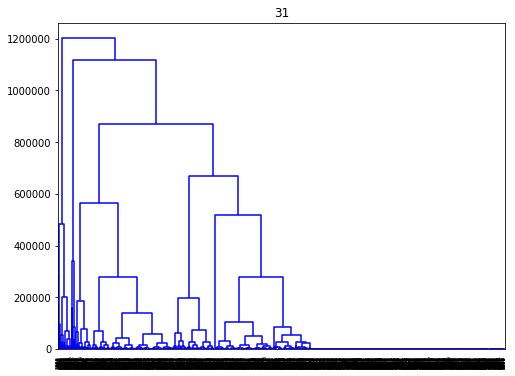

torch.Size([358, 256]) (358, 7)


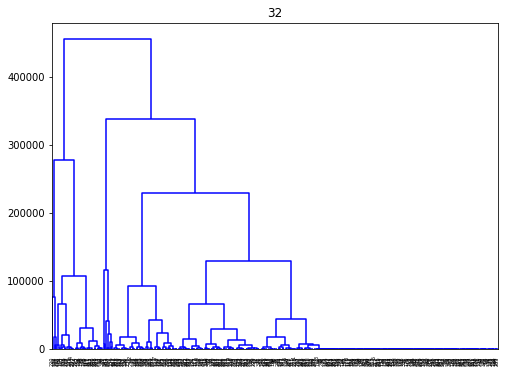

CPU times: user 4min 12s, sys: 26 s, total: 4min 38s
Wall time: 3min 51s


In [21]:
%%time
iclusters = np.ones(length)
try:
    for batch_number, waveform in enumerate(train_loader):        
        batch_size = waveform.size()[0]
        constructed = np.concatenate((parameters[batch_number*BATCH:batch_number*BATCH+batch_size],parameters2[batch_number*BATCH:batch_number*BATCH+batch_size]),axis=1)
        
        outputs = GEN(waveform.float())
        
        feature = outputs[1].view(batch_size,-1)
        print(feature.shape,constructed.shape)
        feature = np.concatenate((constructed,feature.detach().numpy()),axis=1)
        
        linkmatrix = fc.linkage(constructed, method="ward")

        fig = plt.figure(figsize=(8, 6))
        dn = dendrogram(linkmatrix, count_sort=True, color_threshold=0)
        plt.title(batch_number)
        plt.show()
        
        clusters = fcluster(linkmatrix, 10, criterion='maxclust')
        counter = batch_number*BATCH
        iclusters[counter:counter+batch_size] = clusters
        
#         for i,j in enumerate(waveform):
#             plt.figure(figsize=(8,6))
#             plt.plot(waveform[i][0].detach().numpy(),label="heat")
#             plt.plot(waveform[i][1].detach().numpy(),label="light")
#             plt.legend()
#             plt.title("{}".format(clusters[i]))
#             plt.show()
        
except KeyboardInterrupt:
    print('Training ended early.')

0.07529120241350748
0.07538611799079895
0.00724212114799699
0.007214669677940221
0.00019002904352919775
0.00019008483038385898
0.29982390613557974


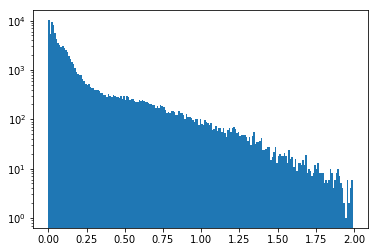

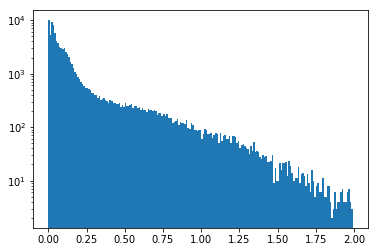

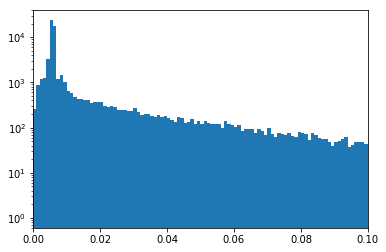

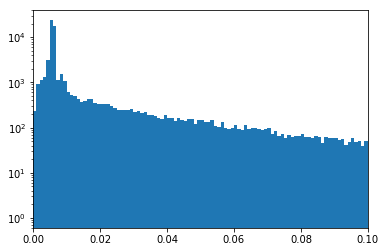

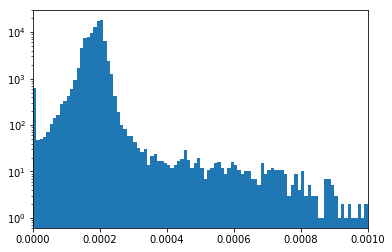

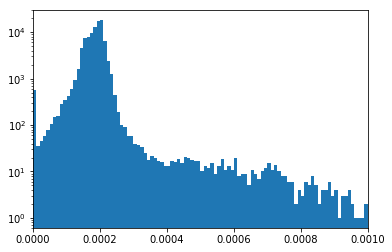

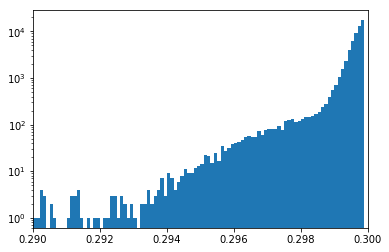

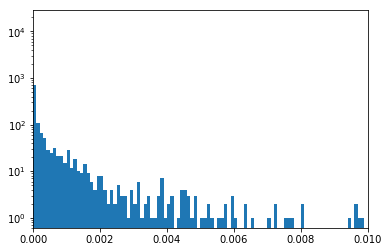

In [11]:
group = 20
# tester = len(Photon[iclusters==group])

# print(parameters[len(Photon[iclusters==group]),0].shape)

print(np.median(parameters[:,0]))
print(np.median(parameters[:,1]))
print(np.median(parameters[:,2]))
print(np.median(parameters[:,3]))

print(np.median(parameters2[:,0]))
print(np.median(parameters2[:,1]))
print(np.median(parameters2[:,2]))

plt.figure()
plt.hist(parameters[:,0], bins=np.arange(0,2,0.01))
plt.yscale("log")
plt.show()

plt.figure()
plt.hist(parameters[:,1], bins=np.arange(0,2,0.01))
plt.yscale("log")
plt.show()

plt.figure()
plt.hist(parameters[:,2], bins=np.arange(0,1,0.001))
plt.xlim(0,0.1)
plt.yscale("log")
plt.show()

plt.figure()
plt.hist(parameters[:,3], bins=np.arange(0,1,0.001))
plt.xlim(0,0.1)
plt.yscale("log")
plt.show()

plt.figure()
plt.hist(parameters2[:,0], bins=np.arange(0,0.02,0.00001))
plt.xlim(0,0.001)
plt.yscale("log")
plt.show()

plt.figure()
plt.hist(parameters2[:,1], bins=np.arange(0,0.02,0.00001))
plt.xlim(0,0.001)
plt.yscale("log")
plt.show()

plt.figure()
plt.hist(parameters2[:,2], bins=np.arange(0,0.3,0.0001))
plt.xlim(0.29,0.3)
plt.yscale("log")
plt.show()

plt.figure()
plt.hist(parameters2[:,2], bins=np.arange(0,0.3,0.0001))
plt.xlim(0,0.01)
plt.yscale("log")
plt.show()

# Try Heat/Heat+light

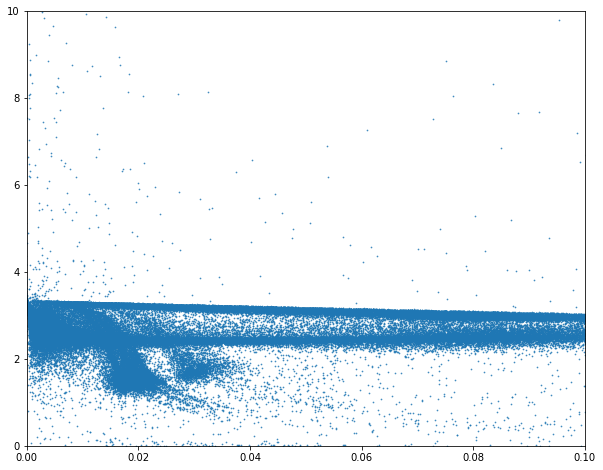

In [33]:
# plt.figure(figsize=(10,8))
# plt.plot


mod_x = energy_heat1
# mod_y = np.multiply(ratio1,parameters[:,0])
# mod_y = energy_light/energy_heat1*parameters2[:,2]
mod_y = energy_light/(energy_heat1+energy_light*parameters2[:,2])

plt.figure(figsize=(10,8))
plt.scatter(mod_x,mod_y, alpha=0.8, marker=".", s=2)
plt.xlim(0,0.1)
plt.ylim(0,10)
plt.show()

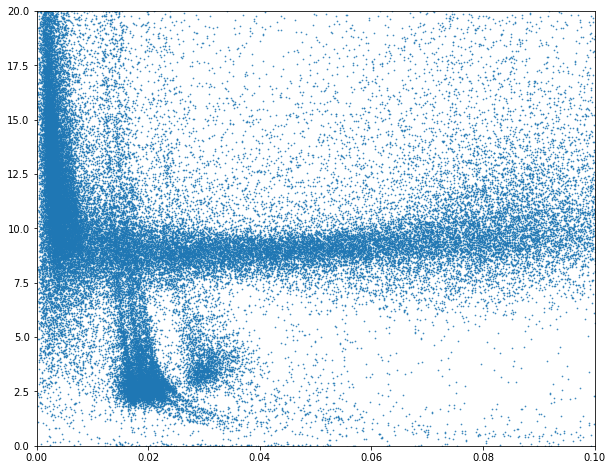

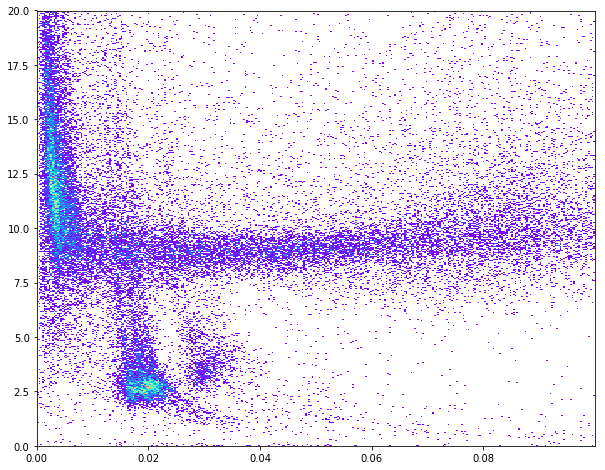

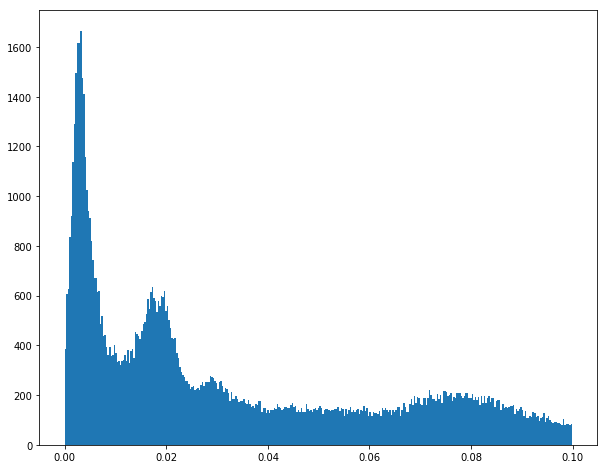

In [191]:
plt.figure(figsize=(10,8))
plt.scatter(energy_heat1,ratio1, alpha=0.8, marker=".", s=2)
plt.xlim(0,0.1)
plt.ylim(0,20)
plt.show()

plt.figure(figsize=(10,8))
plt.hist2d(energy_heat1,ratio1,bins=(np.arange(0,0.1,0.0003),np.arange(0,20,0.03)), 
           cmin=0.1, cmap="rainbow")
# plt.xlim(0,0.1)
# plt.ylim(0,20)
plt.show()

# plt.figure(figsize=(10,8))
# plt.hist(energy_heat1,bins=np.arange(0,0.1,0.0003))
# plt.show()